# 1.bandpass

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/model_line.zip' -d '/content/drive/MyDrive/model_line'

Archive:  /content/drive/MyDrive/model_line.zip
   creating: /content/drive/MyDrive/model_line/model_line/
   creating: /content/drive/MyDrive/model_line/model_line/band/
  inflating: /content/drive/MyDrive/model_line/model_line/band/test_band_line.csv  
  inflating: /content/drive/MyDrive/model_line/model_line/band/train_band_line.csv  
  inflating: /content/drive/MyDrive/model_line/model_line/band/valid_band_line.csv  
   creating: /content/drive/MyDrive/model_line/model_line/high/
  inflating: /content/drive/MyDrive/model_line/model_line/high/test_high_line.csv  
  inflating: /content/drive/MyDrive/model_line/model_line/high/train_high_line.csv  
  inflating: /content/drive/MyDrive/model_line/model_line/high/valid_high_line.csv  
   creating: /content/drive/MyDrive/model_line/model_line/low/
  inflating: /content/drive/MyDrive/model_line/model_line/low/test_low_line.csv  
  inflating: /content/drive/MyDrive/model_line/model_line/low/train_low_line.csv  
  inflating: /content/drive/M

In [ ]:
import os
import itertools
import time
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import (CosineAnnealingLR,
                                      CosineAnnealingWarmRestarts,
                                      StepLR,
                                      ExponentialLR)

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, auc, f1_score, precision_score, recall_score

In [ ]:
import tqdm, re, sys
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import plot_confusion_matrix
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, BatchNormalization, Dense
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint

In [ ]:
data_train = pd.read_csv('/content/drive/MyDrive/model_line/model_line/band/train_band_line.csv', header=None)
data_test = pd.read_csv('/content/drive/MyDrive/model_line/model_line/band/test_band_line.csv', header=None)
data_val= pd.read_csv('/content/drive/MyDrive/model_line/model_line/band/valid_band_line.csv', header=None)

In [ ]:
data_test

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,-0.013974,-0.011168,-0.009118,-0.008067,-0.008125,-0.009210,-0.011005,-0.012983,-0.014471,-0.014771,...,0.006733,0.009824,0.013030,0.016239,0.019380,0.022418,0.025327,0.028062,0.030516,0.032514
1,-0.168748,-0.165213,-0.162149,-0.159616,-0.157617,-0.156088,-0.154895,-0.153851,-0.152741,-0.151345,...,-0.112212,-0.109266,-0.106187,-0.103433,-0.101427,-0.100452,-0.100579,-0.101653,-0.103329,-0.105151
2,-0.065523,-0.063387,-0.062618,-0.063184,-0.064857,-0.067233,-0.069777,-0.071909,-0.073104,-0.072994,...,-0.108012,-0.104863,-0.102909,-0.101926,-0.101481,-0.101056,-0.100197,-0.098638,-0.096375,-0.093669
3,0.517435,0.633848,0.709706,0.733996,0.703265,0.622346,0.503432,0.363695,0.221988,0.095392,...,-0.079957,-0.067902,-0.046360,-0.023911,-0.006614,0.002560,0.003524,-0.001689,-0.009950,-0.018044
4,-0.069052,-0.066942,-0.064951,-0.062974,-0.060851,-0.058435,-0.055658,-0.052576,-0.049378,-0.046363,...,-0.134398,-0.135559,-0.138471,-0.142558,-0.147015,-0.150950,-0.153535,-0.154163,-0.152557,-0.148830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0.004594,0.009590,0.017135,0.025880,0.034416,0.041620,0.046867,0.050103,0.051777,0.052674,...,0.045016,0.016083,-0.009705,-0.032355,-0.052129,-0.069386,-0.084460,-0.097612,-0.109031,-0.118868
5996,0.017135,0.017694,0.019432,0.022356,0.026302,0.030971,0.035976,0.040891,0.045291,0.048799,...,0.005152,0.044268,0.089211,0.134152,0.171846,0.194955,0.197629,0.176948,0.133840,0.073184
5997,-0.061678,-0.060521,-0.059365,-0.058206,-0.057080,-0.056067,-0.055283,-0.054843,-0.054816,-0.055175,...,-0.046773,-0.050592,-0.052317,-0.052018,-0.049965,-0.046587,-0.042433,-0.038139,-0.034393,-0.031913
5998,-0.039287,-0.039374,-0.039054,-0.038510,-0.037933,-0.037494,-0.037327,-0.037532,-0.038153,-0.039167,...,-0.058137,-0.060069,-0.061489,-0.061986,-0.061385,-0.059834,-0.057803,-0.055972,-0.055062,-0.055631


In [ ]:
data_train.shape

(24000, 256)

## 라벨생성

In [ ]:
arr = np.array([])

for i in range(1,101):
  for j in range(240):
    arr = np.append(arr, np.array([i]))

In [ ]:
data_train[256]=arr

In [ ]:
data_train

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,-0.031820,-0.015874,-0.001172,0.011249,0.020713,0.026974,0.030190,0.030831,0.029559,0.027102,...,-0.035003,-0.034647,-0.033418,-0.031305,-0.028545,-0.025565,-0.022868,-0.020891,-0.019891,1.0
1,-0.019872,-0.020594,-0.021637,-0.022515,-0.022798,-0.022202,-0.020644,-0.018236,-0.015233,-0.011971,...,-0.072854,-0.070401,-0.067539,-0.064716,-0.062285,-0.060443,-0.059208,-0.058448,-0.057940,1.0
2,-0.057454,-0.056822,-0.055984,-0.054985,-0.053945,-0.052999,-0.052250,-0.051733,-0.051414,-0.051213,...,-0.059447,-0.057278,-0.056011,-0.055424,-0.055246,-0.055239,-0.055275,-0.055352,-0.055577,1.0
3,-0.056099,-0.057035,-0.058395,-0.060043,-0.061694,-0.062967,-0.063465,-0.062887,-0.061116,-0.058272,...,-0.071806,-0.071741,-0.071302,-0.070367,-0.068861,-0.066758,-0.064085,-0.060936,-0.057487,1.0
4,0.053295,0.053439,0.055066,0.059409,0.067278,0.078961,0.094216,0.112361,0.132422,0.153321,...,0.150072,0.164082,0.180535,0.199168,0.219491,0.240843,0.262473,0.283635,0.303673,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,0.043512,0.020932,0.001382,-0.014947,-0.027957,-0.037670,-0.044270,-0.048123,-0.049775,-0.049906,...,-0.020100,-0.018824,-0.018132,-0.018247,-0.019303,-0.021303,-0.024082,-0.027314,-0.030559,100.0
23996,-0.076867,-0.083002,-0.088128,-0.091454,-0.092582,-0.091623,-0.089189,-0.086281,-0.084051,-0.083490,...,-0.019352,-0.019054,-0.016308,-0.011295,-0.004783,0.002224,0.008807,0.014368,0.018726,100.0
23997,0.022090,0.024929,0.027786,0.031100,0.035075,0.039622,0.044402,0.048933,0.052740,0.055510,...,-0.053679,-0.057318,-0.059515,-0.061043,-0.062554,-0.064528,-0.067243,-0.070758,-0.074902,100.0
23998,-0.079288,-0.083358,-0.086464,-0.087995,-0.087513,-0.084880,-0.080336,-0.074488,-0.068211,-0.062467,...,-0.066882,-0.067113,-0.068424,-0.070704,-0.073600,-0.076563,-0.078930,-0.080050,-0.079413,100.0


In [ ]:
arr_t = np.array([])

for i in range(1,101):
  for j in range(60):
    arr_t = np.append(arr_t, np.array([i]))

In [ ]:
arr_v = np.array([])

for i in range(1,101):
  for j in range(60):
    arr_v = np.append(arr_v, np.array([i]))

In [ ]:
data_test[256]=arr_t
data_val[256]=arr_v
data_val

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,-0.054004,-0.050825,-0.048322,-0.046824,-0.046532,-0.047445,-0.049330,-0.051735,-0.054058,-0.055645,...,-0.028530,-0.029492,-0.029945,-0.029648,-0.028487,-0.026485,-0.023782,-0.020603,-0.017228,1.0
1,-0.209505,-0.208403,-0.206688,-0.204586,-0.202338,-0.200196,-0.198379,-0.197017,-0.196097,-0.195447,...,-0.205948,-0.202740,-0.198907,-0.194673,-0.190228,-0.185713,-0.181227,-0.176850,-0.172660,1.0
2,-0.067735,-0.065806,-0.063513,-0.060990,-0.058453,-0.056174,-0.054439,-0.053477,-0.053402,-0.054158,...,-0.093394,-0.093535,-0.092581,-0.090373,-0.086983,-0.082689,-0.077914,-0.073148,-0.068878,1.0
3,-0.002916,-0.007004,-0.012949,-0.020332,-0.028344,-0.035829,-0.041422,-0.043775,-0.041865,-0.035337,...,-0.097242,-0.124400,-0.137850,-0.128147,-0.087559,-0.012153,0.096530,0.230711,0.376848,1.0
4,-0.028844,-0.028027,-0.028309,-0.029364,-0.030767,-0.032072,-0.032878,-0.032899,-0.032005,-0.030247,...,-0.074225,-0.075851,-0.077197,-0.077950,-0.077920,-0.077074,-0.075531,-0.073514,-0.071283,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0.015685,0.016545,0.014765,0.010665,0.004884,-0.001771,-0.008494,-0.014652,-0.019878,-0.024092,...,-0.052522,-0.020671,0.001335,0.013226,0.016606,0.014270,0.009428,0.004988,0.003041,100.0
5996,-0.171624,-0.175496,-0.177258,-0.176626,-0.173694,-0.168915,-0.163017,-0.156862,-0.151287,-0.146943,...,0.013368,0.016800,0.019352,0.020889,0.021392,0.020985,0.019940,0.018650,0.017569,100.0
5997,0.000168,-0.001110,-0.003542,-0.006028,-0.007548,-0.007396,-0.005302,-0.001433,0.003712,0.009473,...,-0.072272,-0.071268,-0.070220,-0.069094,-0.067885,-0.066618,-0.065335,-0.064074,-0.062856,100.0
5998,-0.033347,-0.035287,-0.036169,-0.036014,-0.035070,-0.033744,-0.032503,-0.031760,-0.031802,-0.032746,...,-0.036757,-0.033683,-0.032034,-0.031757,-0.032584,-0.034107,-0.035874,-0.037486,-0.038665,100.0


In [ ]:
# y_train = arr
# y_test = arr_t
# y_val = arr_v

## 데이터 전체 섞기

In [ ]:
data_total=pd.concat([data_train, data_test, data_val])
data_total

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,-0.031820,-0.015874,-0.001172,0.011249,0.020713,0.026974,0.030190,0.030831,0.029559,0.027102,...,-0.035003,-0.034647,-0.033418,-0.031305,-0.028545,-0.025565,-0.022868,-0.020891,-0.019891,1.0
1,-0.019872,-0.020594,-0.021637,-0.022515,-0.022798,-0.022202,-0.020644,-0.018236,-0.015233,-0.011971,...,-0.072854,-0.070401,-0.067539,-0.064716,-0.062285,-0.060443,-0.059208,-0.058448,-0.057940,1.0
2,-0.057454,-0.056822,-0.055984,-0.054985,-0.053945,-0.052999,-0.052250,-0.051733,-0.051414,-0.051213,...,-0.059447,-0.057278,-0.056011,-0.055424,-0.055246,-0.055239,-0.055275,-0.055352,-0.055577,1.0
3,-0.056099,-0.057035,-0.058395,-0.060043,-0.061694,-0.062967,-0.063465,-0.062887,-0.061116,-0.058272,...,-0.071806,-0.071741,-0.071302,-0.070367,-0.068861,-0.066758,-0.064085,-0.060936,-0.057487,1.0
4,0.053295,0.053439,0.055066,0.059409,0.067278,0.078961,0.094216,0.112361,0.132422,0.153321,...,0.150072,0.164082,0.180535,0.199168,0.219491,0.240843,0.262473,0.283635,0.303673,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0.015685,0.016545,0.014765,0.010665,0.004884,-0.001771,-0.008494,-0.014652,-0.019878,-0.024092,...,-0.052522,-0.020671,0.001335,0.013226,0.016606,0.014270,0.009428,0.004988,0.003041,100.0
5996,-0.171624,-0.175496,-0.177258,-0.176626,-0.173694,-0.168915,-0.163017,-0.156862,-0.151287,-0.146943,...,0.013368,0.016800,0.019352,0.020889,0.021392,0.020985,0.019940,0.018650,0.017569,100.0
5997,0.000168,-0.001110,-0.003542,-0.006028,-0.007548,-0.007396,-0.005302,-0.001433,0.003712,0.009473,...,-0.072272,-0.071268,-0.070220,-0.069094,-0.067885,-0.066618,-0.065335,-0.064074,-0.062856,100.0
5998,-0.033347,-0.035287,-0.036169,-0.036014,-0.035070,-0.033744,-0.032503,-0.031760,-0.031802,-0.032746,...,-0.036757,-0.033683,-0.032034,-0.031757,-0.032584,-0.034107,-0.035874,-0.037486,-0.038665,100.0


In [ ]:
data_total=data_total.sample(frac=1)

In [ ]:
data_train=data_total.iloc[0:24000, :]
data_val=data_total.iloc[24000:30000, :]
data_test=data_total.iloc[30000:36000,:]

In [ ]:
data_train

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
2931,0.093075,0.083780,0.074598,0.066240,0.059178,0.053574,0.049267,0.045813,0.042554,0.038727,...,-0.021742,-0.018312,-0.014072,-0.008702,-0.002122,0.005451,0.013496,0.021243,0.027773,49.0
9134,0.062594,0.043542,0.026331,0.011100,-0.002136,-0.013390,-0.022658,-0.029900,-0.035072,-0.038172,...,-0.008176,-0.011257,-0.017116,-0.025439,-0.035572,-0.046571,-0.057305,-0.066604,-0.073445,39.0
16633,-0.052265,-0.058428,-0.064190,-0.069700,-0.074866,-0.079454,-0.083214,-0.085939,-0.087489,-0.087764,...,-0.029825,-0.026519,-0.024759,-0.026030,-0.031248,-0.040349,-0.052036,-0.063769,-0.072071,70.0
21085,-0.031926,-0.029382,-0.027998,-0.028225,-0.030224,-0.033753,-0.038146,-0.042391,-0.045306,-0.045782,...,0.281163,0.308788,0.306347,0.273150,0.213806,0.137352,0.055393,-0.020318,-0.080210,88.0
3939,-0.040913,-0.048534,-0.055368,-0.060233,-0.062451,-0.062108,-0.060157,-0.058294,-0.058604,-0.063013,...,0.009137,0.017063,0.027065,0.038950,0.052250,0.066308,0.080408,0.093909,0.106350,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1950,0.101418,0.104209,0.107024,0.110509,0.115404,0.122480,0.132406,0.145571,0.161941,0.180962,...,-0.144181,-0.149649,-0.154869,-0.158562,-0.159769,-0.158063,-0.153639,-0.147231,-0.139908,33.0
2559,0.006331,0.001729,-0.003743,-0.009459,-0.014882,-0.019655,-0.023610,-0.026728,-0.029039,-0.030529,...,-0.000696,-0.001551,-0.002893,-0.004604,-0.006442,-0.008118,-0.009409,-0.010245,-0.010763,43.0
14305,-0.073399,-0.073273,-0.074355,-0.076096,-0.077895,-0.079249,-0.079873,-0.079751,-0.079111,-0.078337,...,-0.068108,-0.072968,-0.076441,-0.078125,-0.077893,-0.075899,-0.072532,-0.068328,-0.063859,60.0
7228,0.014458,0.025175,0.034781,0.042367,0.047363,0.049621,0.049390,0.047233,0.043879,0.040069,...,-0.198819,-0.186027,-0.156859,-0.117200,-0.073893,-0.033323,-0.000290,0.022628,0.035142,31.0


## 데이터 따로 섞기

In [ ]:
data_train = data_train.sample(frac=1).reset_index(drop=True)
data_test = data_test.sample(frac=1).reset_index(drop=True)
data_val = data_val.sample(frac=1).reset_index(drop=True)

In [ ]:
data_train

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,0.013167,0.017490,0.018646,0.016446,0.011114,0.003245,-0.006287,-0.016464,-0.026283,-0.034921,...,-0.004174,-0.002091,0.000968,0.004741,0.008918,0.013208,0.017364,0.021204,0.024627,72.0
1,-0.115512,-0.115289,-0.113396,-0.110355,-0.106877,-0.103780,-0.101890,-0.101913,-0.104281,-0.108999,...,0.008242,0.022894,0.039154,0.056616,0.074825,0.093340,0.111823,0.130108,0.148236,54.0
2,-0.009042,-0.008103,-0.008920,-0.010897,-0.013278,-0.015248,-0.016029,-0.014967,-0.011609,-0.005777,...,-0.041403,-0.040630,-0.041345,-0.043381,-0.046298,-0.049451,-0.052130,-0.053720,-0.053853,61.0
3,0.402142,0.302911,0.185292,0.066715,-0.037182,-0.115259,-0.162345,-0.179306,-0.171868,-0.148656,...,-0.079294,-0.081055,-0.082744,-0.083994,-0.084521,-0.084185,-0.083029,-0.081281,-0.079306,40.0
4,-0.007963,0.005535,0.017452,0.026380,0.031221,0.031279,0.026293,0.016416,0.002152,-0.015730,...,0.008343,-0.091526,-0.188443,-0.269607,-0.325108,-0.349555,-0.342722,-0.309150,-0.256869,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,-0.109838,-0.112002,-0.113641,-0.114621,-0.114863,-0.114353,-0.113177,-0.111554,-0.109847,-0.108525,...,-0.108024,-0.108699,-0.108706,-0.108044,-0.106867,-0.105405,-0.103864,-0.102335,-0.100754,62.0
23996,-0.040675,-0.054378,-0.068501,-0.081380,-0.091338,-0.096999,-0.097585,-0.093149,-0.084687,-0.074089,...,0.001157,0.069442,0.143595,0.214329,0.271583,0.306394,0.312725,0.288831,0.237771,41.0
23997,-0.019681,-0.041208,-0.061138,-0.078153,-0.091414,-0.100656,-0.106163,-0.108632,-0.108992,-0.108220,...,-0.045588,-0.048637,-0.051353,-0.053427,-0.054666,-0.054988,-0.054436,-0.053175,-0.051491,35.0
23998,0.003074,-0.012424,-0.024224,-0.032849,-0.039069,-0.043762,-0.047765,-0.051742,-0.056075,-0.060821,...,-0.119279,-0.118505,-0.116912,-0.114928,-0.113008,-0.111522,-0.110699,-0.110611,-0.111212,98.0


## 전처리

In [ ]:
y_train = to_categorical(data_train[256])
y_test = to_categorical(data_test[256])
y_val = to_categorical(data_val[256])
# y_train = to_categorical(arr)
# y_test = to_categorical(arr_t)
# y_val = to_categorical(arr_v)
y_train[23999]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [ ]:
data_train.drop([256], axis=1, inplace=True)
data_test.drop([256], axis=1, inplace=True)
data_val.drop([256], axis=1, inplace=True)
data_train

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
2931,0.093075,0.083780,0.074598,0.066240,0.059178,0.053574,0.049267,0.045813,0.042554,0.038727,...,-0.024828,-0.021742,-0.018312,-0.014072,-0.008702,-0.002122,0.005451,0.013496,0.021243,0.027773
9134,0.062594,0.043542,0.026331,0.011100,-0.002136,-0.013390,-0.022658,-0.029900,-0.035072,-0.038172,...,-0.007846,-0.008176,-0.011257,-0.017116,-0.025439,-0.035572,-0.046571,-0.057305,-0.066604,-0.073445
16633,-0.052265,-0.058428,-0.064190,-0.069700,-0.074866,-0.079454,-0.083214,-0.085939,-0.087489,-0.087764,...,-0.033089,-0.029825,-0.026519,-0.024759,-0.026030,-0.031248,-0.040349,-0.052036,-0.063769,-0.072071
21085,-0.031926,-0.029382,-0.027998,-0.028225,-0.030224,-0.033753,-0.038146,-0.042391,-0.045306,-0.045782,...,0.229120,0.281163,0.308788,0.306347,0.273150,0.213806,0.137352,0.055393,-0.020318,-0.080210
3939,-0.040913,-0.048534,-0.055368,-0.060233,-0.062451,-0.062108,-0.060157,-0.058294,-0.058604,-0.063013,...,0.003183,0.009137,0.017063,0.027065,0.038950,0.052250,0.066308,0.080408,0.093909,0.106350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1950,0.101418,0.104209,0.107024,0.110509,0.115404,0.122480,0.132406,0.145571,0.161941,0.180962,...,-0.139767,-0.144181,-0.149649,-0.154869,-0.158562,-0.159769,-0.158063,-0.153639,-0.147231,-0.139908
2559,0.006331,0.001729,-0.003743,-0.009459,-0.014882,-0.019655,-0.023610,-0.026728,-0.029039,-0.030529,...,-0.000266,-0.000696,-0.001551,-0.002893,-0.004604,-0.006442,-0.008118,-0.009409,-0.010245,-0.010763
14305,-0.073399,-0.073273,-0.074355,-0.076096,-0.077895,-0.079249,-0.079873,-0.079751,-0.079111,-0.078337,...,-0.062467,-0.068108,-0.072968,-0.076441,-0.078125,-0.077893,-0.075899,-0.072532,-0.068328,-0.063859
7228,0.014458,0.025175,0.034781,0.042367,0.047363,0.049621,0.049390,0.047233,0.043879,0.040069,...,-0.191666,-0.198819,-0.186027,-0.156859,-0.117200,-0.073893,-0.033323,-0.000290,0.022628,0.035142


In [ ]:
X_train=data_train.values
X_test=data_test.values
X_val=data_val.values

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(24000, 256)
(6000, 256)
(6000, 256)
(24000, 101)
(6000, 101)
(6000, 101)


In [ ]:
# X_train = X_train.reshape(1, 256, 24000)
# X_test = X_test.reshape(1, 256, 6000)
# X_val = X_val.reshape(1, 256, 6000)
X_train = X_train.reshape(24000, 256, 1)
X_test = X_test.reshape(6000, 256, 1)
X_val = X_val.reshape(6000, 256, 1)
X_train.shape, X_test.shape, X_val.shape

((24000, 256, 1), (6000, 256, 1), (6000, 256, 1))

## cnn-lstm 모델

In [ ]:
def model():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(256, 1)))
    model.add(BatchNormalization())
    
    # adding a pooling layer
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(256, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(256, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Flatten())
    #model.add(Dense(64, activation='relu'))
    #model.add(Dense(64, activation='relu'))
    model.add(Dense(101, activation='softmax'))
    
    model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
    return model

In [ ]:
model = model()
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_17 (Conv1D)          (None, 256, 64)           448       
                                                                 
 batch_normalization_12 (Bat  (None, 256, 64)          256       
 chNormalization)                                                
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 128, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_18 (Conv1D)          (None, 128, 64)           24640     
                                                                 
 batch_normalization_13 (Bat  (None, 128, 64)          256       
 chNormalization)                                                
                                                     

## cnn-gru 모델

In [ ]:
from keras.layers import Input, Embedding, GRU, LSTM, MaxPooling1D, GlobalMaxPool1D, CuDNNGRU
from keras.layers import Dropout, Dense, Activation, Flatten, Conv1D, SpatialDropout1D
from keras.models import Sequential

model = Sequential()

model.add(Conv1D(filters=64, kernel_size=6, activation='relu', padding='same', input_shape=(256, 1)))
model.add(SpatialDropout1D(0.2))
model.add(MaxPooling1D(4))
model.add(CuDNNGRU(64))

model.add(Dropout(0.1))
model.add(Dense(101, activation='softmax'))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_13 (Conv1D)          (None, 256, 64)           448       
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 256, 64)          0         
 lDropout1D)                                                     
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 64, 64)           0         
 g1D)                                                            
                                                                 
 cu_dnngru_4 (CuDNNGRU)      (None, 64)                24960     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 101)              

## gru모델

In [ ]:
from keras.layers import Input, Embedding, GRU, LSTM, SimpleRNN, MaxPooling1D, GlobalMaxPool1D, CuDNNGRU
from keras.layers import Dropout, Dense, Activation, Flatten, Conv1D, SpatialDropout1D
from keras.models import Sequential

model = Sequential()
model.add(GRU(units=100, return_sequences=True, input_shape=(256,1))) #shape[1]=열
model.add(GRU(units=50, return_sequences=True))
model.add(GRU(units=50, return_sequences=True))

model.add(Flatten())
model.add(Dropout(0.1))

model.add(Dense(101, activation='softmax'))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_22 (GRU)                (None, 256, 100)          30900     
                                                                 
 gru_23 (GRU)                (None, 256, 50)           22800     
                                                                 
 gru_24 (GRU)                (None, 256, 50)           15300     
                                                                 
 flatten_3 (Flatten)         (None, 12800)             0         
                                                                 
 dropout_11 (Dropout)        (None, 12800)             0         
                                                                 
 dense_1 (Dense)             (None, 101)               1292901   
                                                                 
Total params: 1,361,901
Trainable params: 1,361,901
No

## LSTM

In [ ]:
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(256,1))) #shape[1]=열
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50, return_sequences=True))

model.add(Flatten())
model.add(Dropout(0.1))

model.add(Dense(101, activation='softmax'))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 256, 100)          40800     
                                                                 
 lstm_4 (LSTM)               (None, 256, 50)           30200     
                                                                 
 lstm_5 (LSTM)               (None, 256, 50)           20200     
                                                                 
 flatten_6 (Flatten)         (None, 12800)             0         
                                                                 
 dropout_6 (Dropout)         (None, 12800)             0         
                                                                 
 dense_8 (Dense)             (None, 101)               1292901   
                                                                 
Total params: 1,384,101
Trainable params: 1,384,101
No

## RNN모델

In [ ]:
from keras.layers import Input, Embedding, GRU, LSTM, SimpleRNN, MaxPooling1D, GlobalMaxPool1D, CuDNNGRU
from keras.layers import Dropout, Dense, Activation, Flatten, Conv1D, SpatialDropout1D
from keras.models import Sequential

model = Sequential()
model.add(SimpleRNN(units=100, return_sequences=True, input_shape=(256,1))) #shape[1]=열
model.add(SimpleRNN(units=50, return_sequences=True))
model.add(SimpleRNN(units=50, return_sequences=True))

model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(101, activation='softmax'))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_12 (SimpleRNN)   (None, 256, 100)          10200     
                                                                 
 simple_rnn_13 (SimpleRNN)   (None, 256, 50)           7550      
                                                                 
 simple_rnn_14 (SimpleRNN)   (None, 256, 50)           5050      
                                                                 
 flatten_4 (Flatten)         (None, 12800)             0         
                                                                 
 dropout_4 (Dropout)         (None, 12800)             0         
                                                                 
 dense_5 (Dense)             (None, 101)               1292901   
                                                                 
Total params: 1,315,701
Trainable params: 1,315,701
No

## CNN

In [ ]:
def model():
  model = Sequential()
  model.add(Conv1D(256, 8, padding='same', activation='relu', input_shape= (256,1)))
  model.add(MaxPooling1D())
  model.add(Conv1D(256, 8, padding='same', activation='relu'))
  model.add(MaxPooling1D())
  model.add(Conv1D(64, 8, padding='same',activation='relu'))
  model.add(MaxPooling1D())
  model.add(Conv1D(64, 8, padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(Flatten())
  model.add(Dense(101, activation='softmax')) # activation='softmax'

  model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

In [ ]:
model=model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 256, 256)          2304      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 128, 256)         0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 128, 256)          524544    
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 64, 256)          0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 64, 64)            131136    
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 32, 64)          

## 모델학습/평가

In [ ]:
history = model.fit(X_train, y_train, batch_size = 1024, epochs = 1000, verbose = 1, validation_data=(X_val, y_val))

Epoch 1/1000
24/24 [==============================] - 8s 167ms/step - loss: 0.0098 - accuracy: 0.0075 - val_loss: 0.0098 - val_accuracy: 0.0063
Epoch 2/1000
24/24 [==============================] - 3s 129ms/step - loss: 0.0098 - accuracy: 0.0096 - val_loss: 0.0098 - val_accuracy: 0.0093
Epoch 3/1000
24/24 [==============================] - 3s 130ms/step - loss: 0.0098 - accuracy: 0.0093 - val_loss: 0.0098 - val_accuracy: 0.0073
Epoch 4/1000
24/24 [==============================] - 3s 130ms/step - loss: 0.0098 - accuracy: 0.0117 - val_loss: 0.0098 - val_accuracy: 0.0077
Epoch 5/1000
24/24 [==============================] - 3s 130ms/step - loss: 0.0098 - accuracy: 0.0121 - val_loss: 0.0098 - val_accuracy: 0.0058
Epoch 6/1000
24/24 [==============================] - 3s 131ms/step - loss: 0.0098 - accuracy: 0.0122 - val_loss: 0.0098 - val_accuracy: 0.0097
Epoch 7/1000
24/24 [==============================] - 3s 131ms/step - loss: 0.0098 - accuracy: 0.0150 - val_loss: 0.0098 - val_accuracy:

In [ ]:
model.evaluate(X_test, y_test)

188/188 [==============================] - 2s 10ms/step - loss: 0.0011 - accuracy: 0.9293


[0.0011083399876952171, 0.9293333292007446]

In [ ]:
model.save('bandpass_1s.h5')

## 그래프 분석

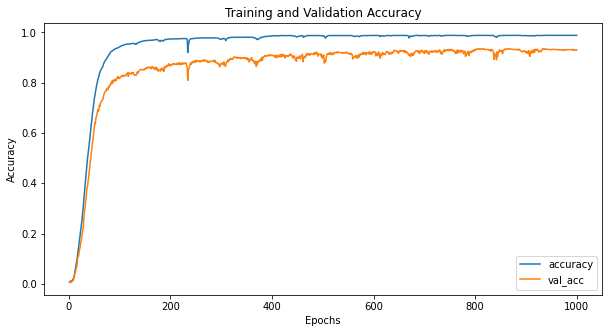

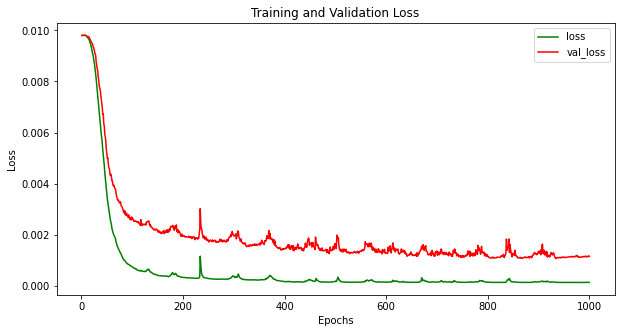

In [ ]:
history=history.history
epochs = range(1, len(history['loss']) + 1)
acc = history['accuracy']
loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

plt.figure(figsize=(10, 5))
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label='val_acc')
plt.legend()

plt.figure(figsize=(10, 5))
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, label='loss', color='g')
plt.plot(epochs, val_loss, label='val_loss', color='r')
plt.legend()


## 예측해보기(predict)

In [ ]:
y_pred = model.predict(X_test)

188/188 [==============================] - 3s 10ms/step


In [ ]:
y_test_p=pd.DataFrame(y_test)

for i in range(1,101):
  y_test_p.loc[y_test_p[i] == 1.0 , 'y_test'] = i  
y_test_p.y_test

0       75.0
1       90.0
2       67.0
3       91.0
4       84.0
        ... 
5995    44.0
5996    37.0
5997    99.0
5998    88.0
5999    31.0
Name: y_test, Length: 6000, dtype: float64

In [ ]:
# ch1 = pd.DataFrame(np.rint(y_pred))
# for i in range(1,101):
#   ch1.loc[ch1[i] == 1.0 , 'pred'] = i 

 
#predict = pd.concat([data_test,ch1['pred'], y_test_p['y_test']],axis = 1)

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,pred
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
5996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.0
5997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0
5998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.0


In [ ]:
ex=np.argmax(y_pred, axis=1)
ex=ex.astype('float64')
ex=pd.DataFrame(ex)
ex

,0
0,75.0
1,90.0
2,67.0
3,91.0
4,84.0
...,...
5995,44.0
5996,37.0
5997,99.0
5998,88.0


In [ ]:
ch1 = pd.DataFrame(np.rint(y_pred))
ch1['pred'] = ex
data_test.reset_index(inplace=True, drop=True)
predict = pd.concat([data_test,ch1['pred'], y_test_p['y_test']],axis = 1)

In [ ]:
predict['compare'] = np.where(predict['pred']==predict['y_test'],'yes', 'no')

In [ ]:
predict_1 = predict[predict["compare"]=='no']
predict_1

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,pred,y_test,compare
8,0.034902,0.040244,0.046107,0.052067,0.057719,0.062743,0.066955,0.070322,0.072960,0.075095,...,0.085447,0.084625,0.083489,0.081097,0.076492,0.069015,0.058567,18.0,2.0,no
11,0.109717,0.110659,0.111964,0.114482,0.118950,0.125818,0.135116,0.146405,0.158831,0.171282,...,-0.046100,-0.047511,-0.047318,-0.046095,-0.044528,-0.043274,-0.042820,2.0,92.0,no
26,0.014270,0.001147,-0.009664,-0.017843,-0.023431,-0.026793,-0.028535,-0.029376,-0.030009,-0.030962,...,-0.023292,-0.026665,-0.030282,-0.033635,-0.035797,-0.035559,-0.031681,10.0,8.0,no
27,-0.030546,-0.028344,-0.027399,-0.027423,-0.028062,-0.029064,-0.030394,-0.032242,-0.034932,-0.038768,...,0.005832,0.002299,-0.006270,-0.020143,-0.038324,-0.058224,-0.075590,66.0,47.0,no
35,-0.025196,-0.024448,-0.023728,-0.023056,-0.022438,-0.021864,-0.021319,-0.020791,-0.020296,-0.019888,...,0.045220,0.041943,0.036367,0.029059,0.020812,0.012487,0.004854,96.0,8.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5904,-0.023422,-0.018496,-0.014607,-0.011922,-0.010307,-0.009338,-0.008411,-0.006905,-0.004374,-0.000691,...,-0.045415,-0.049928,-0.055818,-0.062579,-0.069229,-0.074560,-0.077474,18.0,94.0,no
5911,0.031127,0.030208,0.029620,0.029588,0.030140,0.031080,0.032028,0.032515,0.032121,0.030616,...,-0.026762,-0.027985,-0.028425,-0.028331,-0.027923,-0.027419,-0.027036,95.0,49.0,no
5943,0.063536,0.071162,0.078900,0.086882,0.095225,0.103941,0.112881,0.121710,0.129939,0.136985,...,-0.053988,-0.052298,-0.050341,-0.048330,-0.046442,-0.044802,-0.043505,29.0,42.0,no
5972,-0.043211,-0.041627,-0.039691,-0.037799,-0.036304,-0.035467,-0.035429,-0.036219,-0.037772,-0.039970,...,-0.225394,-0.183337,-0.113905,-0.020055,0.090091,0.203977,0.306470,39.0,30.0,no


# 2.highpass

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/model_line.zip' -d '/content/drive/MyDrive/model_line'

Archive:  /content/drive/MyDrive/model_line.zip
   creating: /content/drive/MyDrive/model_line/model_line/
   creating: /content/drive/MyDrive/model_line/model_line/band/
  inflating: /content/drive/MyDrive/model_line/model_line/band/test_band_line.csv  
  inflating: /content/drive/MyDrive/model_line/model_line/band/train_band_line.csv  
  inflating: /content/drive/MyDrive/model_line/model_line/band/valid_band_line.csv  
   creating: /content/drive/MyDrive/model_line/model_line/high/
  inflating: /content/drive/MyDrive/model_line/model_line/high/test_high_line.csv  
  inflating: /content/drive/MyDrive/model_line/model_line/high/train_high_line.csv  
  inflating: /content/drive/MyDrive/model_line/model_line/high/valid_high_line.csv  
   creating: /content/drive/MyDrive/model_line/model_line/low/
  inflating: /content/drive/MyDrive/model_line/model_line/low/test_low_line.csv  
  inflating: /content/drive/MyDrive/model_line/model_line/low/train_low_line.csv  
  inflating: /content/drive/M

In [ ]:
import os
import itertools
import time
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import (CosineAnnealingLR,
                                      CosineAnnealingWarmRestarts,
                                      StepLR,
                                      ExponentialLR)

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, auc, f1_score, precision_score, recall_score

In [ ]:
import tqdm, re, sys
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import plot_confusion_matrix
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, BatchNormalization, Dense
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint

In [ ]:
data_train = pd.read_csv('/content/drive/MyDrive/model_line/model_line/high/train_high_line.csv', header=None)
data_test = pd.read_csv('/content/drive/MyDrive/model_line/model_line/high/test_high_line.csv', header=None)
data_val= pd.read_csv('/content/drive/MyDrive/model_line/model_line/high/valid_high_line.csv', header=None)

In [ ]:
data_test

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0.004293,-0.108721,-0.025203,0.050075,0.041975,-0.079525,-0.019323,0.040809,0.003013,-0.044322,...,0.025460,0.090296,-0.007490,-0.026310,0.053336,0.110380,0.044460,-0.027323,0.009700,0.105980
1,-0.178025,-0.129949,-0.154714,-0.190879,-0.147544,-0.149849,-0.139385,-0.184831,-0.160077,-0.125704,...,-0.158946,-0.192521,-0.104194,-0.074016,-0.121687,-0.121997,-0.143646,-0.113273,-0.137490,-0.137856
2,-0.118486,-0.135978,-0.021999,0.014580,-0.094641,-0.135181,-0.068231,0.024199,-0.080811,-0.151051,...,-0.012902,-0.057865,-0.169278,-0.139103,-0.051629,0.003184,-0.126743,-0.173762,-0.090042,-0.026942
3,0.595354,0.768205,0.751377,0.729010,0.837712,0.799024,0.553267,0.214589,0.034092,0.025435,...,-0.060304,-0.051033,0.071048,0.039479,-0.059981,-0.111832,0.002407,0.031495,-0.068237,-0.108500
4,-0.107180,-0.029394,-0.003439,-0.114145,-0.110911,-0.047808,0.014365,-0.074943,-0.107671,-0.060639,...,-0.104624,-0.173071,-0.158586,-0.065081,-0.066074,-0.202336,-0.198327,-0.087227,-0.061546,-0.158424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,-0.006009,0.035463,0.031765,0.034116,0.041276,0.040276,0.043814,0.049392,0.014919,0.082215,...,0.032174,0.025207,0.017123,-0.047797,-0.036055,-0.080359,-0.080849,-0.131536,-0.108450,-0.119801
5996,-0.004209,-0.021269,0.014421,0.066451,0.034102,0.022313,0.039954,0.015126,0.016828,0.095201,...,-0.002060,-0.007017,-0.001635,0.073427,0.119448,0.241599,0.262261,0.279691,0.237252,0.092732
5997,-0.052598,-0.055633,-0.055577,-0.032002,-0.095826,-0.056251,-0.088205,-0.003379,-0.041393,-0.062797,...,-0.038018,-0.060236,-0.027453,-0.048409,-0.078653,-0.040536,-0.018418,-0.062418,-0.006057,0.010865
5998,-0.039242,-0.044322,-0.024571,-0.017190,-0.044918,-0.038277,-0.066724,-0.033992,-0.049339,-0.018386,...,-0.089395,-0.019348,-0.078060,-0.082112,-0.081604,-0.070175,-0.080676,-0.072666,0.004694,-0.046835


In [ ]:
data_train.shape

(24000, 256)

## 라벨생성

In [ ]:
arr = np.array([])

for i in range(1,101):
  for j in range(240):
    arr = np.append(arr, np.array([i]))

In [ ]:
data_train[256]=arr

In [ ]:
data_train

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,-0.011566,0.077466,0.083038,0.015121,-0.024216,0.026618,0.112943,0.067018,-0.022367,0.035899,...,-0.080380,-0.088511,0.005901,-0.000657,-0.066214,-0.061900,-0.011674,0.064162,-0.020820,1.0
1,-0.105411,0.006199,0.035219,-0.038238,-0.087385,-0.047431,0.057264,0.011541,-0.063622,-0.054354,...,-0.102607,-0.121740,-0.038993,-0.017367,-0.083201,-0.108995,-0.055099,0.004076,-0.050829,1.0
2,-0.124635,-0.101820,-0.004986,-0.009573,-0.097080,-0.078287,-0.033934,0.011788,-0.100740,-0.105788,...,-0.087241,-0.110820,-0.037730,0.000719,-0.066072,-0.119163,-0.068725,0.003512,-0.040881,1.0
3,-0.070665,-0.110059,-0.041584,0.011091,-0.073945,-0.116371,-0.065348,0.005895,-0.075523,-0.138241,...,-0.074093,-0.113909,-0.113364,-0.053677,-0.015389,-0.088530,-0.122749,-0.019986,-0.033522,1.0
4,0.164484,0.137004,0.165505,0.176745,0.186086,0.149056,0.190527,0.256168,0.278809,0.242770,...,0.168813,0.158065,0.156737,0.236019,0.242662,0.237836,0.242839,0.272923,0.371568,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,0.047641,0.025272,0.001593,0.008873,-0.022388,-0.055809,-0.067971,-0.044163,-0.045987,-0.032190,...,-0.062754,0.002815,-0.032905,-0.016336,-0.045078,0.004621,-0.020431,0.005698,-0.048605,100.0
23996,-0.017653,0.005880,-0.008398,-0.053956,-0.045114,-0.050892,-0.014791,-0.025570,-0.044989,-0.027848,...,-0.017953,0.000676,0.008635,-0.010605,0.004606,0.032398,0.011841,-0.004365,0.032981,100.0
23997,0.020267,0.062224,-0.014968,0.012301,0.073691,0.025622,0.056645,0.040058,0.073452,0.061997,...,-0.057440,-0.065800,-0.044000,-0.082399,-0.083447,-0.065335,-0.088911,-0.080017,-0.076062,100.0
23998,-0.091136,-0.072359,-0.082491,-0.096773,-0.108624,-0.106044,-0.096813,-0.094621,-0.049099,-0.103425,...,-0.095215,-0.045811,-0.093347,-0.052513,-0.086620,-0.069087,-0.056044,-0.095822,-0.080069,100.0


In [ ]:
arr_t = np.array([])

for i in range(1,101):
  for j in range(60):
    arr_t = np.append(arr_t, np.array([i]))

In [ ]:
arr_v = np.array([])

for i in range(1,101):
  for j in range(60):
    arr_v = np.append(arr_v, np.array([i]))

In [ ]:
data_test[256]=arr_t
data_val[256]=arr_v
data_val

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,-0.088677,-0.125790,-0.030982,0.007508,-0.029261,-0.106478,-0.080494,-0.011038,-0.021531,-0.121852,...,0.017174,-0.070759,-0.096122,0.007007,-0.004853,-0.026522,-0.062090,0.001993,0.019837,1.0
1,-0.166172,-0.207399,-0.221436,-0.207283,-0.178781,-0.161000,-0.193089,-0.206398,-0.157608,-0.133839,...,-0.207781,-0.165102,-0.191124,-0.196126,-0.205478,-0.184471,-0.151804,-0.194417,-0.193371,1.0
2,-0.145358,-0.148342,-0.020535,-0.017398,-0.130030,-0.147643,-0.060204,0.013275,-0.095876,-0.130336,...,-0.085840,-0.182494,-0.152887,-0.014291,-0.043764,-0.122897,-0.128260,-0.017722,-0.028884,1.0
3,0.071963,0.015509,-0.112935,-0.062499,0.079877,-0.016757,-0.127871,-0.039045,0.030101,0.042338,...,-0.033357,0.015213,-0.075836,-0.154705,-0.100604,-0.008633,0.015829,0.039830,0.248372,1.0
4,-0.041662,0.030685,-0.020187,-0.129210,-0.085054,0.044992,0.021448,-0.110557,-0.113222,-0.015198,...,-0.124194,-0.064253,-0.014054,-0.089064,-0.151946,-0.088977,-0.031070,-0.035743,-0.117336,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0.032231,0.030567,-0.020890,0.050221,0.017189,-0.008196,-0.015203,-0.032563,-0.038065,-0.040280,...,-0.038393,-0.042812,-0.032542,0.037526,-0.009246,0.006291,0.019648,-0.020407,-0.015023,100.0
5996,-0.196898,-0.177660,-0.151701,-0.170922,-0.196274,-0.164125,-0.167807,-0.145068,-0.153429,-0.147951,...,-0.014796,0.048950,0.007776,0.021993,0.008940,0.032578,0.035396,0.003384,0.046122,100.0
5997,0.014198,-0.011697,-0.009543,-0.048490,-0.005837,0.002504,-0.030444,0.011946,0.002635,0.027564,...,-0.081514,-0.086519,-0.102934,-0.041559,-0.065864,-0.047559,-0.085704,-0.048828,-0.085453,100.0
5998,-0.048497,-0.030079,-0.042822,-0.063725,-0.028908,-0.011291,-0.015405,-0.037688,-0.033962,-0.027736,...,-0.023651,-0.016484,-0.058906,0.005502,-0.050809,-0.055031,-0.001622,-0.067492,-0.039172,100.0


In [ ]:
# y_train = arr
# y_test = arr_t
# y_val = arr_v

## 데이터 전체 섞기

In [ ]:
data_total=pd.concat([data_train, data_test, data_val])
data_total

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,-0.011566,0.077466,0.083038,0.015121,-0.024216,0.026618,0.112943,0.067018,-0.022367,0.035899,...,-0.080380,-0.088511,0.005901,-0.000657,-0.066214,-0.061900,-0.011674,0.064162,-0.020820,1.0
1,-0.105411,0.006199,0.035219,-0.038238,-0.087385,-0.047431,0.057264,0.011541,-0.063622,-0.054354,...,-0.102607,-0.121740,-0.038993,-0.017367,-0.083201,-0.108995,-0.055099,0.004076,-0.050829,1.0
2,-0.124635,-0.101820,-0.004986,-0.009573,-0.097080,-0.078287,-0.033934,0.011788,-0.100740,-0.105788,...,-0.087241,-0.110820,-0.037730,0.000719,-0.066072,-0.119163,-0.068725,0.003512,-0.040881,1.0
3,-0.070665,-0.110059,-0.041584,0.011091,-0.073945,-0.116371,-0.065348,0.005895,-0.075523,-0.138241,...,-0.074093,-0.113909,-0.113364,-0.053677,-0.015389,-0.088530,-0.122749,-0.019986,-0.033522,1.0
4,0.164484,0.137004,0.165505,0.176745,0.186086,0.149056,0.190527,0.256168,0.278809,0.242770,...,0.168813,0.158065,0.156737,0.236019,0.242662,0.237836,0.242839,0.272923,0.371568,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0.032231,0.030567,-0.020890,0.050221,0.017189,-0.008196,-0.015203,-0.032563,-0.038065,-0.040280,...,-0.038393,-0.042812,-0.032542,0.037526,-0.009246,0.006291,0.019648,-0.020407,-0.015023,100.0
5996,-0.196898,-0.177660,-0.151701,-0.170922,-0.196274,-0.164125,-0.167807,-0.145068,-0.153429,-0.147951,...,-0.014796,0.048950,0.007776,0.021993,0.008940,0.032578,0.035396,0.003384,0.046122,100.0
5997,0.014198,-0.011697,-0.009543,-0.048490,-0.005837,0.002504,-0.030444,0.011946,0.002635,0.027564,...,-0.081514,-0.086519,-0.102934,-0.041559,-0.065864,-0.047559,-0.085704,-0.048828,-0.085453,100.0
5998,-0.048497,-0.030079,-0.042822,-0.063725,-0.028908,-0.011291,-0.015405,-0.037688,-0.033962,-0.027736,...,-0.023651,-0.016484,-0.058906,0.005502,-0.050809,-0.055031,-0.001622,-0.067492,-0.039172,100.0


In [ ]:
data_total=data_total.sample(frac=1)

In [ ]:
data_train=data_total.iloc[0:24000, :]
data_val=data_total.iloc[24000:30000, :]
data_test=data_total.iloc[30000:36000,:]

In [ ]:
data_train

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
2160,-0.067399,-0.055313,-0.074646,-0.114919,-0.088871,-0.111103,-0.079715,-0.080806,-0.070167,-0.029497,...,0.017222,0.009899,-0.004473,0.059794,0.014011,-0.047852,-0.048926,-0.075550,-0.053034,37.0
20919,-0.039001,-0.049287,-0.064703,-0.075447,-0.068599,-0.085801,-0.038972,-0.034171,-0.073489,-0.067426,...,-0.050403,-0.042220,-0.078167,-0.022235,-0.015043,-0.028401,-0.049329,-0.014087,-0.047666,88.0
973,0.013016,-0.011119,-0.039795,0.015698,-0.013839,-0.056547,-0.028326,0.008265,-0.002105,-0.010835,...,-0.108325,-0.112022,-0.108531,-0.119081,-0.121462,-0.090844,-0.160078,-0.088232,-0.114928,17.0
1238,-0.012839,-0.007891,-0.000335,-0.017209,-0.042385,0.004278,-0.018220,0.001170,-0.015320,-0.020522,...,-0.041861,-0.045602,-0.031203,0.011176,-0.056984,-0.035815,-0.028645,-0.029925,-0.026754,6.0
4149,0.162093,0.259302,0.278531,0.214980,0.245281,0.184952,0.160723,0.035515,-0.023882,-0.040479,...,-0.051584,-0.040018,-0.069031,-0.051542,-0.050382,-0.028941,-0.031798,-0.047034,-0.036189,70.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8202,-0.006040,-0.023679,-0.003979,0.004199,0.014016,0.003021,-0.013575,-0.007312,-0.046171,-0.016271,...,-0.066009,-0.075146,-0.032192,0.024472,0.087386,0.153660,0.207485,0.299180,0.282465,35.0
5298,-0.234748,-0.194218,-0.143088,-0.116647,-0.096146,-0.075835,-0.060663,-0.047532,-0.003239,-0.032327,...,-0.004386,-0.045173,-0.044530,-0.004445,-0.020140,-0.004285,-0.043359,-0.019732,-0.003674,89.0
4371,-0.042573,-0.026527,-0.038931,-0.040005,-0.065119,-0.035112,0.002794,-0.054849,-0.045523,-0.051146,...,0.046142,0.003203,0.054244,0.003735,0.000176,-0.011942,0.004859,0.008150,-0.002779,73.0
3576,0.039162,-0.001734,0.004371,-0.030724,0.003882,0.129788,0.027695,0.035203,0.010411,-0.036581,...,-0.120116,-0.078387,-0.139557,-0.167027,-0.096697,-0.065567,-0.172236,-0.129005,-0.096974,15.0


## 데이터 따로 섞기

In [ ]:
data_train = data_train.sample(frac=1).reset_index(drop=True)
data_test = data_test.sample(frac=1).reset_index(drop=True)
data_val = data_val.sample(frac=1).reset_index(drop=True)

In [ ]:
data_train

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,0.013167,0.017490,0.018646,0.016446,0.011114,0.003245,-0.006287,-0.016464,-0.026283,-0.034921,...,-0.004174,-0.002091,0.000968,0.004741,0.008918,0.013208,0.017364,0.021204,0.024627,72.0
1,-0.115512,-0.115289,-0.113396,-0.110355,-0.106877,-0.103780,-0.101890,-0.101913,-0.104281,-0.108999,...,0.008242,0.022894,0.039154,0.056616,0.074825,0.093340,0.111823,0.130108,0.148236,54.0
2,-0.009042,-0.008103,-0.008920,-0.010897,-0.013278,-0.015248,-0.016029,-0.014967,-0.011609,-0.005777,...,-0.041403,-0.040630,-0.041345,-0.043381,-0.046298,-0.049451,-0.052130,-0.053720,-0.053853,61.0
3,0.402142,0.302911,0.185292,0.066715,-0.037182,-0.115259,-0.162345,-0.179306,-0.171868,-0.148656,...,-0.079294,-0.081055,-0.082744,-0.083994,-0.084521,-0.084185,-0.083029,-0.081281,-0.079306,40.0
4,-0.007963,0.005535,0.017452,0.026380,0.031221,0.031279,0.026293,0.016416,0.002152,-0.015730,...,0.008343,-0.091526,-0.188443,-0.269607,-0.325108,-0.349555,-0.342722,-0.309150,-0.256869,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,-0.109838,-0.112002,-0.113641,-0.114621,-0.114863,-0.114353,-0.113177,-0.111554,-0.109847,-0.108525,...,-0.108024,-0.108699,-0.108706,-0.108044,-0.106867,-0.105405,-0.103864,-0.102335,-0.100754,62.0
23996,-0.040675,-0.054378,-0.068501,-0.081380,-0.091338,-0.096999,-0.097585,-0.093149,-0.084687,-0.074089,...,0.001157,0.069442,0.143595,0.214329,0.271583,0.306394,0.312725,0.288831,0.237771,41.0
23997,-0.019681,-0.041208,-0.061138,-0.078153,-0.091414,-0.100656,-0.106163,-0.108632,-0.108992,-0.108220,...,-0.045588,-0.048637,-0.051353,-0.053427,-0.054666,-0.054988,-0.054436,-0.053175,-0.051491,35.0
23998,0.003074,-0.012424,-0.024224,-0.032849,-0.039069,-0.043762,-0.047765,-0.051742,-0.056075,-0.060821,...,-0.119279,-0.118505,-0.116912,-0.114928,-0.113008,-0.111522,-0.110699,-0.110611,-0.111212,98.0


## 전처리

In [ ]:
y_train = to_categorical(data_train[256])
y_test = to_categorical(data_test[256])
y_val = to_categorical(data_val[256])
# y_train = to_categorical(arr)
# y_test = to_categorical(arr_t)
# y_val = to_categorical(arr_v)
y_train[23999]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [ ]:
data_train.drop([256], axis=1, inplace=True)
data_test.drop([256], axis=1, inplace=True)
data_val.drop([256], axis=1, inplace=True)
data_train

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
2160,-0.067399,-0.055313,-0.074646,-0.114919,-0.088871,-0.111103,-0.079715,-0.080806,-0.070167,-0.029497,...,0.018093,0.017222,0.009899,-0.004473,0.059794,0.014011,-0.047852,-0.048926,-0.075550,-0.053034
20919,-0.039001,-0.049287,-0.064703,-0.075447,-0.068599,-0.085801,-0.038972,-0.034171,-0.073489,-0.067426,...,-0.120486,-0.050403,-0.042220,-0.078167,-0.022235,-0.015043,-0.028401,-0.049329,-0.014087,-0.047666
973,0.013016,-0.011119,-0.039795,0.015698,-0.013839,-0.056547,-0.028326,0.008265,-0.002105,-0.010835,...,-0.084478,-0.108325,-0.112022,-0.108531,-0.119081,-0.121462,-0.090844,-0.160078,-0.088232,-0.114928
1238,-0.012839,-0.007891,-0.000335,-0.017209,-0.042385,0.004278,-0.018220,0.001170,-0.015320,-0.020522,...,-0.037809,-0.041861,-0.045602,-0.031203,0.011176,-0.056984,-0.035815,-0.028645,-0.029925,-0.026754
4149,0.162093,0.259302,0.278531,0.214980,0.245281,0.184952,0.160723,0.035515,-0.023882,-0.040479,...,0.028871,-0.051584,-0.040018,-0.069031,-0.051542,-0.050382,-0.028941,-0.031798,-0.047034,-0.036189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8202,-0.006040,-0.023679,-0.003979,0.004199,0.014016,0.003021,-0.013575,-0.007312,-0.046171,-0.016271,...,-0.098162,-0.066009,-0.075146,-0.032192,0.024472,0.087386,0.153660,0.207485,0.299180,0.282465
5298,-0.234748,-0.194218,-0.143088,-0.116647,-0.096146,-0.075835,-0.060663,-0.047532,-0.003239,-0.032327,...,-0.024578,-0.004386,-0.045173,-0.044530,-0.004445,-0.020140,-0.004285,-0.043359,-0.019732,-0.003674
4371,-0.042573,-0.026527,-0.038931,-0.040005,-0.065119,-0.035112,0.002794,-0.054849,-0.045523,-0.051146,...,0.037911,0.046142,0.003203,0.054244,0.003735,0.000176,-0.011942,0.004859,0.008150,-0.002779
3576,0.039162,-0.001734,0.004371,-0.030724,0.003882,0.129788,0.027695,0.035203,0.010411,-0.036581,...,-0.109445,-0.120116,-0.078387,-0.139557,-0.167027,-0.096697,-0.065567,-0.172236,-0.129005,-0.096974


In [ ]:
X_train=data_train.values
X_test=data_test.values
X_val=data_val.values

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(24000, 256)
(6000, 256)
(6000, 256)
(24000, 101)
(6000, 101)
(6000, 101)


In [ ]:
# X_train = X_train.reshape(1, 256, 24000)
# X_test = X_test.reshape(1, 256, 6000)
# X_val = X_val.reshape(1, 256, 6000)
X_train = X_train.reshape(24000, 256, 1)
X_test = X_test.reshape(6000, 256, 1)
X_val = X_val.reshape(6000, 256, 1)
X_train.shape, X_test.shape, X_val.shape

((24000, 256, 1), (6000, 256, 1), (6000, 256, 1))

## cnn-lstm 모델

In [ ]:
def model():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(256, 1)))
    model.add(BatchNormalization())
    
    # adding a pooling layer
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(256, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(256, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Flatten())
    #model.add(Dense(64, activation='relu'))
    #model.add(Dense(64, activation='relu'))
    model.add(Dense(101, activation='softmax'))
    
    model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
    return model

In [ ]:
model = model()
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_17 (Conv1D)          (None, 256, 64)           448       
                                                                 
 batch_normalization_12 (Bat  (None, 256, 64)          256       
 chNormalization)                                                
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 128, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_18 (Conv1D)          (None, 128, 64)           24640     
                                                                 
 batch_normalization_13 (Bat  (None, 128, 64)          256       
 chNormalization)                                                
                                                     

## cnn-gru 모델

In [ ]:
from keras.layers import Input, Embedding, GRU, LSTM, MaxPooling1D, GlobalMaxPool1D, CuDNNGRU
from keras.layers import Dropout, Dense, Activation, Flatten, Conv1D, SpatialDropout1D
from keras.models import Sequential

model = Sequential()

model.add(Conv1D(filters=64, kernel_size=6, activation='relu', padding='same', input_shape=(256, 1)))
model.add(SpatialDropout1D(0.2))
model.add(MaxPooling1D(4))
model.add(CuDNNGRU(64))

model.add(Dropout(0.1))
model.add(Dense(101, activation='softmax'))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_13 (Conv1D)          (None, 256, 64)           448       
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 256, 64)          0         
 lDropout1D)                                                     
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 64, 64)           0         
 g1D)                                                            
                                                                 
 cu_dnngru_4 (CuDNNGRU)      (None, 64)                24960     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 101)              

## gru모델

In [ ]:
model = Sequential()
model.add(GRU(units=100, return_sequences=True, input_shape=(256,1))) #shape[1]=열
model.add(GRU(units=50, return_sequences=True))
model.add(GRU(units=50, return_sequences=True))

model.add(Flatten())
model.add(Dropout(0.1))

model.add(Dense(101, activation='softmax'))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_34 (GRU)                (None, 256, 100)          30900     
                                                                 
 gru_35 (GRU)                (None, 256, 50)           22800     
                                                                 
 gru_36 (GRU)                (None, 256, 50)           15300     
                                                                 
 flatten_7 (Flatten)         (None, 12800)             0         
                                                                 
 dropout_15 (Dropout)        (None, 12800)             0         
                                                                 
 dense_5 (Dense)             (None, 101)               1292901   
                                                                 
Total params: 1,361,901
Trainable params: 1,361,901
N

## LSTM

In [ ]:
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(256,1))) #shape[1]=열
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50, return_sequences=True))

model.add(Flatten())
model.add(Dropout(0.1))

model.add(Dense(101, activation='softmax'))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 256, 100)          40800     
                                                                 
 lstm_4 (LSTM)               (None, 256, 50)           30200     
                                                                 
 lstm_5 (LSTM)               (None, 256, 50)           20200     
                                                                 
 flatten_6 (Flatten)         (None, 12800)             0         
                                                                 
 dropout_6 (Dropout)         (None, 12800)             0         
                                                                 
 dense_8 (Dense)             (None, 101)               1292901   
                                                                 
Total params: 1,384,101
Trainable params: 1,384,101
No

## RNN모델

In [ ]:
from keras.layers import Input, Embedding, GRU, LSTM, SimpleRNN, MaxPooling1D, GlobalMaxPool1D, CuDNNGRU
from keras.layers import Dropout, Dense, Activation, Flatten, Conv1D, SpatialDropout1D
from keras.models import Sequential

model = Sequential()
model.add(SimpleRNN(units=100, return_sequences=True, input_shape=(256,1))) #shape[1]=열
model.add(SimpleRNN(units=50, return_sequences=True))
model.add(SimpleRNN(units=50, return_sequences=True))

model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(101, activation='softmax'))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_12 (SimpleRNN)   (None, 256, 100)          10200     
                                                                 
 simple_rnn_13 (SimpleRNN)   (None, 256, 50)           7550      
                                                                 
 simple_rnn_14 (SimpleRNN)   (None, 256, 50)           5050      
                                                                 
 flatten_4 (Flatten)         (None, 12800)             0         
                                                                 
 dropout_4 (Dropout)         (None, 12800)             0         
                                                                 
 dense_5 (Dense)             (None, 101)               1292901   
                                                                 
Total params: 1,315,701
Trainable params: 1,315,701
No

## CNN

In [ ]:
def model():
  model = Sequential()
  model.add(Conv1D(256, 8, padding='same', activation='relu', input_shape= (256,1)))
  model.add(MaxPooling1D())
  model.add(Conv1D(256, 8, padding='same', activation='relu'))
  model.add(MaxPooling1D())
  model.add(Conv1D(64, 8, padding='same',activation='relu'))
  model.add(MaxPooling1D())
  model.add(Conv1D(64, 8, padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(Flatten())
  model.add(Dense(101, activation='softmax')) # activation='softmax'

  model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

In [ ]:
model=model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 256, 256)          2304      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 128, 256)         0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 128, 256)          524544    
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 64, 256)          0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 64, 64)            131136    
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 32, 64)          

## 모델학습/평가

In [ ]:
history = model.fit(X_train, y_train, batch_size = 512, epochs = 1000, verbose = 1, validation_data=(X_val, y_val))

Epoch 1/1000
47/47 [==============================] - 8s 92ms/step - loss: 0.0098 - accuracy: 0.0096 - val_loss: 0.0098 - val_accuracy: 0.0120
Epoch 2/1000
47/47 [==============================] - 3s 73ms/step - loss: 0.0098 - accuracy: 0.0097 - val_loss: 0.0098 - val_accuracy: 0.0120
Epoch 3/1000
47/47 [==============================] - 3s 73ms/step - loss: 0.0098 - accuracy: 0.0122 - val_loss: 0.0098 - val_accuracy: 0.0107
Epoch 4/1000
47/47 [==============================] - 3s 73ms/step - loss: 0.0098 - accuracy: 0.0127 - val_loss: 0.0098 - val_accuracy: 0.0118
Epoch 5/1000
47/47 [==============================] - 3s 74ms/step - loss: 0.0098 - accuracy: 0.0175 - val_loss: 0.0098 - val_accuracy: 0.0160
Epoch 6/1000
47/47 [==============================] - 3s 74ms/step - loss: 0.0098 - accuracy: 0.0265 - val_loss: 0.0098 - val_accuracy: 0.0245
Epoch 7/1000
47/47 [==============================] - 3s 74ms/step - loss: 0.0097 - accuracy: 0.0429 - val_loss: 0.0098 - val_accuracy: 0.0290

In [ ]:
model.evaluate(X_test, y_test)

188/188 [==============================] - 2s 9ms/step - loss: 0.0014 - accuracy: 0.9223


[0.0014241042081266642, 0.9223333597183228]

In [ ]:
model.save('highpass_1s.h5')

## 그래프 분석

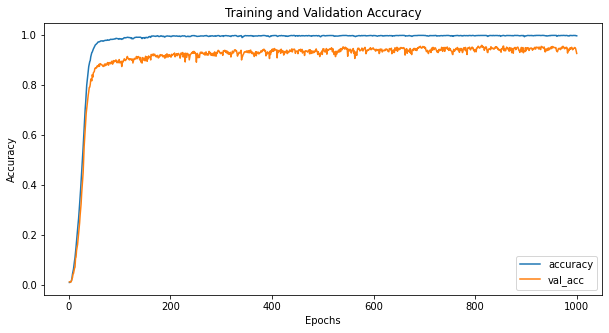

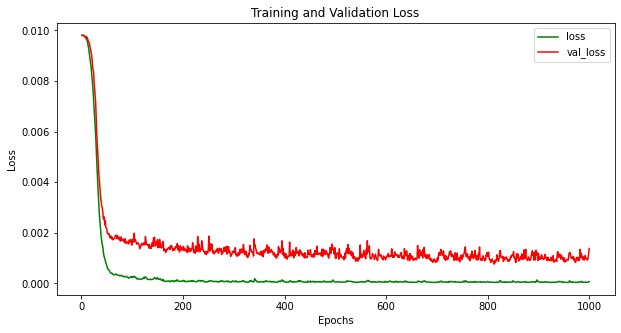

In [ ]:
history=history.history
epochs = range(1, len(history['loss']) + 1)
acc = history['accuracy']
loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

plt.figure(figsize=(10, 5))
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label='val_acc')
plt.legend()

plt.figure(figsize=(10, 5))
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, label='loss', color='g')
plt.plot(epochs, val_loss, label='val_loss', color='r')
plt.legend()


## 예측해보기(predict)

In [ ]:
y_pred = model.predict(X_test)

188/188 [==============================] - 2s 9ms/step


array([[44,  0,  0, ...,  0,  0,  0],
       [ 0, 57,  0, ...,  0,  0,  0],
       [ 0,  0, 65, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 68,  0,  0],
       [ 0,  0,  0, ...,  0, 67,  0],
       [ 0,  0,  0, ...,  0,  0, 57]])

In [ ]:
y_test_p=pd.DataFrame(y_test)

for i in range(1,101):
  y_test_p.loc[y_test_p[i] == 1.0 , 'y_test'] = i  
y_test_p.y_test

0       59.0
1       68.0
2       72.0
3        2.0
4       57.0
        ... 
5995     3.0
5996    87.0
5997    40.0
5998    68.0
5999    37.0
Name: y_test, Length: 6000, dtype: float64

In [ ]:
# ch1 = pd.DataFrame(np.rint(y_pred))
# for i in range(1,101):
#   ch1.loc[ch1[i] == 1.0 , 'pred'] = i 

 
#predict = pd.concat([data_test,ch1['pred'], y_test_p['y_test']],axis = 1)

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,pred
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
5996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.0
5997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0
5998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.0


In [ ]:
ex=np.argmax(y_pred, axis=1)
ex=ex.astype('float64')
ex=pd.DataFrame(ex)
ex

,0
0,59.0
1,68.0
2,72.0
3,2.0
4,57.0
...,...
5995,3.0
5996,87.0
5997,40.0
5998,68.0


In [ ]:
ch1 = pd.DataFrame(np.rint(y_pred))
ch1['pred'] = ex
data_test.reset_index(inplace=True, drop=True)
predict = pd.concat([data_test,ch1['pred'], y_test_p['y_test']],axis = 1)

In [ ]:
predict['compare'] = np.where(predict['pred']==predict['y_test'],'yes', 'no')

In [ ]:
predict_1 = predict[predict["compare"]=='no']
predict_1

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,pred,y_test,compare
30,0.001909,0.008317,0.014489,0.020412,0.025995,0.031137,0.035801,0.040075,0.044195,0.048538,...,0.044631,0.050399,0.057432,0.066046,0.076371,0.088327,0.101648,85.0,36.0,no
46,0.096114,0.095362,0.095047,0.095447,0.096676,0.098677,0.101247,0.104083,0.106844,0.109202,...,-0.004398,-0.008214,-0.013081,-0.019006,-0.025674,-0.032320,-0.037693,83.0,80.0,no
54,-0.041972,-0.048778,-0.055266,-0.061636,-0.067728,-0.073065,-0.076978,-0.078796,-0.078050,-0.074630,...,-0.102289,-0.108650,-0.114708,-0.119718,-0.122885,-0.123496,-0.121095,20.0,71.0,no
55,0.050686,0.056807,0.061922,0.066330,0.070463,0.074831,0.079964,0.086349,0.094365,0.104239,...,0.125449,0.136371,0.147691,0.159697,0.172642,0.186692,0.201860,41.0,50.0,no
71,-0.511413,-0.507140,-0.469849,-0.408462,-0.333769,-0.256404,-0.185178,-0.126038,-0.081724,-0.052058,...,0.031533,0.034874,0.038518,0.042180,0.045745,0.049241,0.052764,4.0,93.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5971,0.005315,-0.043084,-0.083200,-0.110473,-0.122973,-0.121490,-0.109050,-0.090022,-0.069069,-0.050204,...,-0.027012,-0.029614,-0.031356,-0.033020,-0.035244,-0.038329,-0.042129,95.0,23.0,no
5981,-0.005281,-0.018280,-0.031669,-0.042939,-0.050464,-0.053648,-0.052817,-0.048958,-0.043371,-0.037307,...,-0.016826,-0.013496,-0.011275,-0.010594,-0.011830,-0.015208,-0.020697,52.0,40.0,no
5992,-0.084734,-0.091664,-0.098196,-0.101411,-0.098148,-0.085744,-0.062829,-0.030004,0.009808,0.051498,...,0.072150,0.081214,0.090895,0.101388,0.112932,0.125713,0.139775,100.0,83.0,no
5994,0.008461,0.011468,0.012707,0.012096,0.009875,0.006558,0.002841,-0.000513,-0.002782,-0.003375,...,-0.048723,-0.051678,-0.052151,-0.050205,-0.046318,-0.041326,-0.036264,95.0,49.0,no


# 3.lowpass

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/model_line.zip' -d '/content/drive/MyDrive/model_line'

Archive:  /content/drive/MyDrive/model_line.zip
   creating: /content/drive/MyDrive/model_line/model_line/
   creating: /content/drive/MyDrive/model_line/model_line/band/
  inflating: /content/drive/MyDrive/model_line/model_line/band/test_band_line.csv  
  inflating: /content/drive/MyDrive/model_line/model_line/band/train_band_line.csv  
  inflating: /content/drive/MyDrive/model_line/model_line/band/valid_band_line.csv  
   creating: /content/drive/MyDrive/model_line/model_line/high/
  inflating: /content/drive/MyDrive/model_line/model_line/high/test_high_line.csv  
  inflating: /content/drive/MyDrive/model_line/model_line/high/train_high_line.csv  
  inflating: /content/drive/MyDrive/model_line/model_line/high/valid_high_line.csv  
   creating: /content/drive/MyDrive/model_line/model_line/low/
  inflating: /content/drive/MyDrive/model_line/model_line/low/test_low_line.csv  
  inflating: /content/drive/MyDrive/model_line/model_line/low/train_low_line.csv  
  inflating: /content/drive/M

In [ ]:
import os
import itertools
import time
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import (CosineAnnealingLR,
                                      CosineAnnealingWarmRestarts,
                                      StepLR,
                                      ExponentialLR)

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, auc, f1_score, precision_score, recall_score

In [ ]:
import tqdm, re, sys
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import plot_confusion_matrix
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, BatchNormalization, Dense
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint

In [ ]:
data_train = pd.read_csv('/content/drive/MyDrive/model_line/model_line/low/train_low_line.csv', header=None)
data_test = pd.read_csv('/content/drive/MyDrive/model_line/model_line/low/test_low_line.csv', header=None)
data_val= pd.read_csv('/content/drive/MyDrive/model_line/model_line/low/valid_low_line.csv', header=None)

In [ ]:
data_test

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,1.754140,1.756590,1.758298,1.759022,1.758643,1.757236,1.755108,1.752784,1.750938,1.750271,...,1.698640,1.701614,1.704703,1.707794,1.710813,1.713725,1.716508,1.719121,1.721462,1.723356
1,1.590544,1.594114,1.597217,1.599791,1.601832,1.603404,1.604643,1.605734,1.606893,1.608334,...,1.656219,1.659175,1.662269,1.665042,1.667068,1.668064,1.667958,1.666907,1.665254,1.663453
2,1.706668,1.708791,1.709560,1.709006,1.707349,1.704986,1.702446,1.700306,1.699091,1.699173,...,1.656174,1.659317,1.661245,1.662187,1.662586,1.662967,1.663795,1.665342,1.667614,1.670345
3,2.295298,2.411576,2.487373,2.511645,2.480919,2.400025,2.281178,2.141574,2.000075,1.873748,...,1.688096,1.699816,1.720896,1.742862,1.759763,1.768718,1.769686,1.764689,1.756791,1.749115
4,1.705033,1.707353,1.709552,1.711737,1.714067,1.716690,1.719673,1.722960,1.726364,1.729587,...,1.692391,1.691363,1.688594,1.684654,1.680340,1.676541,1.674078,1.673557,1.675256,1.679065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,1.613963,1.619528,1.627568,1.636760,1.645732,1.653393,1.659145,1.662945,1.665238,1.666797,...,1.784428,1.755844,1.730389,1.708044,1.688545,1.671541,1.656708,1.643799,1.632639,1.623080
5996,1.696360,1.696858,1.698535,1.701395,1.705272,1.709867,1.714797,1.719637,1.723966,1.727412,...,1.661005,1.699782,1.744423,1.789141,1.826705,1.849760,1.852416,1.831714,1.788555,1.727819
5997,1.547967,1.549320,1.550668,1.552017,1.553337,1.554553,1.555551,1.556214,1.556469,1.556341,...,1.596446,1.592691,1.591059,1.591456,1.593591,1.597004,1.601126,1.605314,1.608896,1.611187
5998,1.615198,1.615168,1.615529,1.616101,1.616700,1.617167,1.617373,1.617227,1.616682,1.615755,...,1.597461,1.595455,1.593952,1.593380,1.593925,1.595443,1.597461,1.599283,1.600176,1.599565


In [ ]:
data_train.shape

(24000, 256)

## 라벨생성

In [ ]:
arr = np.array([])

for i in range(1,101):
  for j in range(240):
    arr = np.append(arr, np.array([i]))

In [ ]:
data_train[256]=arr

In [ ]:
data_train

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,1.697478,1.713703,1.728594,1.741144,1.750717,1.757105,1.760490,1.761353,1.760349,1.758191,...,1.733012,1.733423,1.734708,1.736879,1.739700,1.742739,1.745491,1.747515,1.748556,1.0
1,1.748610,1.747925,1.746924,1.746097,1.745874,1.746535,1.748158,1.750626,1.753678,1.756978,...,1.694451,1.696899,1.699745,1.702543,1.704941,1.706748,1.707952,1.708690,1.709187,1.0
2,1.709674,1.710317,1.711171,1.712183,1.713227,1.714166,1.714897,1.715389,1.715680,1.715858,...,1.722441,1.724729,1.726115,1.726820,1.727122,1.727259,1.727362,1.727430,1.727353,1.0
3,1.726979,1.726187,1.724966,1.723451,1.721925,1.720776,1.720402,1.721109,1.723015,1.726001,...,1.739826,1.739925,1.740406,1.741383,1.742927,1.745059,1.747751,1.750910,1.754365,1.0
4,1.889883,1.889929,1.891485,1.895719,1.903396,1.914786,1.929653,1.947339,1.966906,1.987309,...,1.914361,1.928167,1.944398,1.962799,1.982890,2.004016,2.025433,2.046399,2.066255,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,1.664913,1.642295,1.622705,1.606331,1.593275,1.583516,1.576874,1.572981,1.571289,1.571116,...,1.609903,1.611269,1.612058,1.612049,1.611103,1.609213,1.606538,1.603402,1.600248,100.0
23996,1.520984,1.516451,1.512894,1.510777,1.510324,1.511420,1.513570,1.515967,1.517666,1.517848,...,1.613789,1.614391,1.617356,1.622495,1.629054,1.636056,1.642622,1.648187,1.652595,100.0
23997,1.656066,1.659062,1.662113,1.665637,1.669814,1.674541,1.679471,1.684122,1.688029,1.690891,...,1.600670,1.597018,1.594806,1.593269,1.591762,1.589812,1.587139,1.583680,1.579595,100.0
23998,1.575260,1.571225,1.568130,1.566590,1.567050,1.569659,1.574187,1.580032,1.586320,1.592084,...,1.579022,1.578733,1.577374,1.575056,1.572128,1.569131,1.566724,1.565555,1.566133,100.0


In [ ]:
arr_t = np.array([])

for i in range(1,101):
  for j in range(60):
    arr_t = np.append(arr_t, np.array([i]))

In [ ]:
arr_v = np.array([])

for i in range(1,101):
  for j in range(60):
    arr_v = np.append(arr_v, np.array([i]))

In [ ]:
data_test[256]=arr_t
data_val[256]=arr_v
data_val

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,1.757857,1.761049,1.763568,1.765083,1.765388,1.764480,1.762595,1.760185,1.757859,1.756279,...,1.742644,1.741366,1.740599,1.740582,1.741420,1.743086,1.745437,1.748252,1.751255,1.0
1,1.544946,1.546049,1.547770,1.549887,1.552157,1.554327,1.556169,1.557550,1.558479,1.559129,...,1.553053,1.556314,1.560194,1.564465,1.568940,1.573478,1.577984,1.582383,1.586600,1.0
2,1.695559,1.697523,1.699848,1.702404,1.704980,1.707305,1.709099,1.710126,1.710271,1.709585,...,1.678932,1.678790,1.679747,1.681958,1.685344,1.689624,1.694374,1.699106,1.703341,1.0
3,1.775055,1.770967,1.765108,1.757903,1.750143,1.742942,1.737608,1.735426,1.737369,1.743771,...,1.681760,1.655004,1.641810,1.651567,1.692000,1.767089,1.875369,2.009146,2.154947,1.0
4,1.724734,1.725498,1.725171,1.724080,1.722647,1.721315,1.720477,1.720418,1.721269,1.722978,...,1.698035,1.696608,1.695459,1.694902,1.695130,1.696178,1.697926,1.700150,1.702592,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,1.528888,1.529840,1.528139,1.524104,1.518376,1.511774,1.505117,1.499054,1.493960,1.489913,...,1.550977,1.583197,1.605661,1.618126,1.622195,1.620631,1.616599,1.612957,1.611750,100.0
5996,1.515056,1.511174,1.509395,1.510004,1.512908,1.517656,1.523524,1.529653,1.535207,1.539537,...,1.693020,1.696392,1.698900,1.700400,1.700869,1.700424,1.699334,1.697991,1.696852,100.0
5997,1.565344,1.564102,1.561757,1.559405,1.558051,1.558382,1.560646,1.564660,1.569916,1.575756,...,1.535411,1.536617,1.537876,1.539222,1.540659,1.542157,1.543669,1.545152,1.546585,100.0
5998,1.597548,1.595698,1.594912,1.595167,1.596213,1.597637,1.598970,1.599797,1.599838,1.598980,...,1.617056,1.620175,1.621880,1.622224,1.621475,1.620038,1.618362,1.616840,1.615746,100.0


In [ ]:
# y_train = arr
# y_test = arr_t
# y_val = arr_v

## 데이터 전체 섞기

In [ ]:
data_total=pd.concat([data_train, data_test, data_val])
data_total

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,1.697478,1.713703,1.728594,1.741144,1.750717,1.757105,1.760490,1.761353,1.760349,1.758191,...,1.733012,1.733423,1.734708,1.736879,1.739700,1.742739,1.745491,1.747515,1.748556,1.0
1,1.748610,1.747925,1.746924,1.746097,1.745874,1.746535,1.748158,1.750626,1.753678,1.756978,...,1.694451,1.696899,1.699745,1.702543,1.704941,1.706748,1.707952,1.708690,1.709187,1.0
2,1.709674,1.710317,1.711171,1.712183,1.713227,1.714166,1.714897,1.715389,1.715680,1.715858,...,1.722441,1.724729,1.726115,1.726820,1.727122,1.727259,1.727362,1.727430,1.727353,1.0
3,1.726979,1.726187,1.724966,1.723451,1.721925,1.720776,1.720402,1.721109,1.723015,1.726001,...,1.739826,1.739925,1.740406,1.741383,1.742927,1.745059,1.747751,1.750910,1.754365,1.0
4,1.889883,1.889929,1.891485,1.895719,1.903396,1.914786,1.929653,1.947339,1.966906,1.987309,...,1.914361,1.928167,1.944398,1.962799,1.982890,2.004016,2.025433,2.046399,2.066255,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,1.528888,1.529840,1.528139,1.524104,1.518376,1.511774,1.505117,1.499054,1.493960,1.489913,...,1.550977,1.583197,1.605661,1.618126,1.622195,1.620631,1.616599,1.612957,1.611750,100.0
5996,1.515056,1.511174,1.509395,1.510004,1.512908,1.517656,1.523524,1.529653,1.535207,1.539537,...,1.693020,1.696392,1.698900,1.700400,1.700869,1.700424,1.699334,1.697991,1.696852,100.0
5997,1.565344,1.564102,1.561757,1.559405,1.558051,1.558382,1.560646,1.564660,1.569916,1.575756,...,1.535411,1.536617,1.537876,1.539222,1.540659,1.542157,1.543669,1.545152,1.546585,100.0
5998,1.597548,1.595698,1.594912,1.595167,1.596213,1.597637,1.598970,1.599797,1.599838,1.598980,...,1.617056,1.620175,1.621880,1.622224,1.621475,1.620038,1.618362,1.616840,1.615746,100.0


In [ ]:
data_total=data_total.sample(frac=1)

In [ ]:
data_train=data_total.iloc[0:24000, :]
data_val=data_total.iloc[24000:30000, :]
data_test=data_total.iloc[30000:36000,:]

In [ ]:
data_train

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
14797,1.575498,1.563810,1.554748,1.551273,1.554579,1.564238,1.578608,1.595385,1.612176,1.626981,...,1.496063,1.497101,1.499070,1.501751,1.504783,1.507710,1.510087,1.511590,1.512108,62.0
4442,1.770798,1.776173,1.783383,1.791552,1.799648,1.806729,1.812172,1.815827,1.818039,1.819563,...,1.857962,1.857110,1.857146,1.858595,1.861911,1.867374,1.874999,1.884480,1.895171,75.0
19385,1.735351,1.746334,1.752386,1.757505,1.764550,1.774997,1.789012,1.805769,1.823886,1.841890,...,1.584464,1.588439,1.592877,1.597272,1.601050,1.603653,1.604633,1.603749,1.601042,81.0
1667,1.701525,1.681062,1.662269,1.645431,1.630848,1.618785,1.609411,1.602731,1.598562,1.596527,...,1.593327,1.591406,1.589981,1.589109,1.588789,1.588973,1.589581,1.590503,1.591591,7.0
19969,1.616300,1.620086,1.621910,1.621008,1.616957,1.609821,1.600242,1.589441,1.579115,1.571215,...,1.652794,1.656397,1.661812,1.669728,1.680872,1.695850,1.714960,1.738014,1.764247,84.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2564,1.569072,1.567932,1.567012,1.566737,1.567516,1.569643,1.573193,1.577953,1.583408,1.588808,...,1.605560,1.596799,1.587624,1.578812,1.571024,1.564695,1.559992,1.556846,1.555039,43.0
17925,1.733440,1.741777,1.750718,1.760091,1.769664,1.779155,1.788254,1.796650,1.804062,1.810267,...,1.694811,1.708601,1.722008,1.732289,1.738204,1.739854,1.738288,1.735035,1.731660,75.0
1922,1.625553,1.627044,1.628636,1.630064,1.631115,1.631655,1.631648,1.631146,1.630273,1.629189,...,1.575915,1.575933,1.575032,1.573324,1.571086,1.568699,1.566545,1.564915,1.563942,9.0
19182,1.829093,1.808695,1.786890,1.764763,1.743234,1.722943,1.704218,1.687110,1.671490,1.657168,...,1.604341,1.608744,1.611719,1.612854,1.612013,1.609360,1.605316,1.600460,1.595409,80.0


## 데이터 따로 섞기

In [ ]:
data_train = data_train.sample(frac=1).reset_index(drop=True)
data_test = data_test.sample(frac=1).reset_index(drop=True)
data_val = data_val.sample(frac=1).reset_index(drop=True)

In [ ]:
data_train

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,0.013167,0.017490,0.018646,0.016446,0.011114,0.003245,-0.006287,-0.016464,-0.026283,-0.034921,...,-0.004174,-0.002091,0.000968,0.004741,0.008918,0.013208,0.017364,0.021204,0.024627,72.0
1,-0.115512,-0.115289,-0.113396,-0.110355,-0.106877,-0.103780,-0.101890,-0.101913,-0.104281,-0.108999,...,0.008242,0.022894,0.039154,0.056616,0.074825,0.093340,0.111823,0.130108,0.148236,54.0
2,-0.009042,-0.008103,-0.008920,-0.010897,-0.013278,-0.015248,-0.016029,-0.014967,-0.011609,-0.005777,...,-0.041403,-0.040630,-0.041345,-0.043381,-0.046298,-0.049451,-0.052130,-0.053720,-0.053853,61.0
3,0.402142,0.302911,0.185292,0.066715,-0.037182,-0.115259,-0.162345,-0.179306,-0.171868,-0.148656,...,-0.079294,-0.081055,-0.082744,-0.083994,-0.084521,-0.084185,-0.083029,-0.081281,-0.079306,40.0
4,-0.007963,0.005535,0.017452,0.026380,0.031221,0.031279,0.026293,0.016416,0.002152,-0.015730,...,0.008343,-0.091526,-0.188443,-0.269607,-0.325108,-0.349555,-0.342722,-0.309150,-0.256869,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,-0.109838,-0.112002,-0.113641,-0.114621,-0.114863,-0.114353,-0.113177,-0.111554,-0.109847,-0.108525,...,-0.108024,-0.108699,-0.108706,-0.108044,-0.106867,-0.105405,-0.103864,-0.102335,-0.100754,62.0
23996,-0.040675,-0.054378,-0.068501,-0.081380,-0.091338,-0.096999,-0.097585,-0.093149,-0.084687,-0.074089,...,0.001157,0.069442,0.143595,0.214329,0.271583,0.306394,0.312725,0.288831,0.237771,41.0
23997,-0.019681,-0.041208,-0.061138,-0.078153,-0.091414,-0.100656,-0.106163,-0.108632,-0.108992,-0.108220,...,-0.045588,-0.048637,-0.051353,-0.053427,-0.054666,-0.054988,-0.054436,-0.053175,-0.051491,35.0
23998,0.003074,-0.012424,-0.024224,-0.032849,-0.039069,-0.043762,-0.047765,-0.051742,-0.056075,-0.060821,...,-0.119279,-0.118505,-0.116912,-0.114928,-0.113008,-0.111522,-0.110699,-0.110611,-0.111212,98.0


## 전처리

In [ ]:
y_train = to_categorical(data_train[256])
y_test = to_categorical(data_test[256])
y_val = to_categorical(data_val[256])
# y_train = to_categorical(arr)
# y_test = to_categorical(arr_t)
# y_val = to_categorical(arr_v)
y_train[23999]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [ ]:
data_train.drop([256], axis=1, inplace=True)
data_test.drop([256], axis=1, inplace=True)
data_val.drop([256], axis=1, inplace=True)
data_train

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
14797,1.575498,1.563810,1.554748,1.551273,1.554579,1.564238,1.578608,1.595385,1.612176,1.626981,...,1.496059,1.496063,1.497101,1.499070,1.501751,1.504783,1.507710,1.510087,1.511590,1.512108
4442,1.770798,1.776173,1.783383,1.791552,1.799648,1.806729,1.812172,1.815827,1.818039,1.819563,...,1.859191,1.857962,1.857110,1.857146,1.858595,1.861911,1.867374,1.874999,1.884480,1.895171
19385,1.735351,1.746334,1.752386,1.757505,1.764550,1.774997,1.789012,1.805769,1.823886,1.841890,...,1.581357,1.584464,1.588439,1.592877,1.597272,1.601050,1.603653,1.604633,1.603749,1.601042
1667,1.701525,1.681062,1.662269,1.645431,1.630848,1.618785,1.609411,1.602731,1.598562,1.596527,...,1.595596,1.593327,1.591406,1.589981,1.589109,1.588789,1.588973,1.589581,1.590503,1.591591
19969,1.616300,1.620086,1.621910,1.621008,1.616957,1.609821,1.600242,1.589441,1.579115,1.571215,...,1.650422,1.652794,1.656397,1.661812,1.669728,1.680872,1.695850,1.714960,1.738014,1.764247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2564,1.569072,1.567932,1.567012,1.566737,1.567516,1.569643,1.573193,1.577953,1.583408,1.588808,...,1.613151,1.605560,1.596799,1.587624,1.578812,1.571024,1.564695,1.559992,1.556846,1.555039
17925,1.733440,1.741777,1.750718,1.760091,1.769664,1.779155,1.788254,1.796650,1.804062,1.810267,...,1.684728,1.694811,1.708601,1.722008,1.732289,1.738204,1.739854,1.738288,1.735035,1.731660
1922,1.625553,1.627044,1.628636,1.630064,1.631115,1.631655,1.631648,1.631146,1.630273,1.629189,...,1.575051,1.575915,1.575933,1.575032,1.573324,1.571086,1.568699,1.566545,1.564915,1.563942
19182,1.829093,1.808695,1.786890,1.764763,1.743234,1.722943,1.704218,1.687110,1.671490,1.657168,...,1.599130,1.604341,1.608744,1.611719,1.612854,1.612013,1.609360,1.605316,1.600460,1.595409


In [ ]:
X_train=data_train.values
X_test=data_test.values
X_val=data_val.values

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(24000, 256)
(6000, 256)
(6000, 256)
(24000, 101)
(6000, 101)
(6000, 101)


In [ ]:
# X_train = X_train.reshape(1, 256, 24000)
# X_test = X_test.reshape(1, 256, 6000)
# X_val = X_val.reshape(1, 256, 6000)
X_train = X_train.reshape(24000, 256, 1)
X_test = X_test.reshape(6000, 256, 1)
X_val = X_val.reshape(6000, 256, 1)
X_train.shape, X_test.shape, X_val.shape

((24000, 256, 1), (6000, 256, 1), (6000, 256, 1))

## cnn-lstm 모델

In [ ]:
def model():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(256, 1)))
    model.add(BatchNormalization())
    
    # adding a pooling layer
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(256, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(256, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Flatten())
    #model.add(Dense(64, activation='relu'))
    #model.add(Dense(64, activation='relu'))
    model.add(Dense(101, activation='softmax'))
    
    model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
    return model

In [ ]:
model = model()
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_17 (Conv1D)          (None, 256, 64)           448       
                                                                 
 batch_normalization_12 (Bat  (None, 256, 64)          256       
 chNormalization)                                                
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 128, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_18 (Conv1D)          (None, 128, 64)           24640     
                                                                 
 batch_normalization_13 (Bat  (None, 128, 64)          256       
 chNormalization)                                                
                                                     

## cnn-gru 모델

In [ ]:
from keras.layers import Input, Embedding, GRU, LSTM, MaxPooling1D, GlobalMaxPool1D, CuDNNGRU
from keras.layers import Dropout, Dense, Activation, Flatten, Conv1D, SpatialDropout1D
from keras.models import Sequential

model = Sequential()

model.add(Conv1D(filters=64, kernel_size=6, activation='relu', padding='same', input_shape=(256, 1)))
model.add(SpatialDropout1D(0.2))
model.add(MaxPooling1D(4))
model.add(CuDNNGRU(64))

model.add(Dropout(0.1))
model.add(Dense(101, activation='softmax'))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_13 (Conv1D)          (None, 256, 64)           448       
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 256, 64)          0         
 lDropout1D)                                                     
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 64, 64)           0         
 g1D)                                                            
                                                                 
 cu_dnngru_4 (CuDNNGRU)      (None, 64)                24960     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 101)              

## gru모델

In [ ]:
model = Sequential()
model.add(GRU(units=100, return_sequences=True, input_shape=(256,1))) #shape[1]=열
model.add(GRU(units=50, return_sequences=True))
model.add(GRU(units=50, return_sequences=True))

model.add(Flatten())
model.add(Dropout(0.1))

model.add(Dense(101, activation='softmax'))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_37 (GRU)                (None, 256, 100)          30900     
                                                                 
 gru_38 (GRU)                (None, 256, 50)           22800     
                                                                 
 gru_39 (GRU)                (None, 256, 50)           15300     
                                                                 
 flatten_8 (Flatten)         (None, 12800)             0         
                                                                 
 dropout_16 (Dropout)        (None, 12800)             0         
                                                                 
 dense_6 (Dense)             (None, 101)               1292901   
                                                                 
Total params: 1,361,901
Trainable params: 1,361,901
N

## LSTM

In [ ]:
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(256,1))) #shape[1]=열
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50, return_sequences=True))

model.add(Flatten())
model.add(Dropout(0.1))

model.add(Dense(101, activation='softmax'))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 256, 100)          40800     
                                                                 
 lstm_4 (LSTM)               (None, 256, 50)           30200     
                                                                 
 lstm_5 (LSTM)               (None, 256, 50)           20200     
                                                                 
 flatten_6 (Flatten)         (None, 12800)             0         
                                                                 
 dropout_6 (Dropout)         (None, 12800)             0         
                                                                 
 dense_8 (Dense)             (None, 101)               1292901   
                                                                 
Total params: 1,384,101
Trainable params: 1,384,101
No

## RNN모델

In [ ]:
from keras.layers import Input, Embedding, GRU, LSTM, SimpleRNN, MaxPooling1D, GlobalMaxPool1D, CuDNNGRU
from keras.layers import Dropout, Dense, Activation, Flatten, Conv1D, SpatialDropout1D
from keras.models import Sequential

model = Sequential()
model.add(SimpleRNN(units=100, return_sequences=True, input_shape=(256,1))) #shape[1]=열
model.add(SimpleRNN(units=50, return_sequences=True))
model.add(SimpleRNN(units=50, return_sequences=True))

model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(101, activation='softmax'))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_12 (SimpleRNN)   (None, 256, 100)          10200     
                                                                 
 simple_rnn_13 (SimpleRNN)   (None, 256, 50)           7550      
                                                                 
 simple_rnn_14 (SimpleRNN)   (None, 256, 50)           5050      
                                                                 
 flatten_4 (Flatten)         (None, 12800)             0         
                                                                 
 dropout_4 (Dropout)         (None, 12800)             0         
                                                                 
 dense_5 (Dense)             (None, 101)               1292901   
                                                                 
Total params: 1,315,701
Trainable params: 1,315,701
No

## CNN

In [ ]:
def model():
  model = Sequential()
  model.add(Conv1D(256, 8, padding='same', activation='relu', input_shape= (256,1)))
  model.add(MaxPooling1D())
  model.add(Conv1D(256, 8, padding='same', activation='relu'))
  model.add(MaxPooling1D())
  model.add(Conv1D(64, 8, padding='same',activation='relu'))
  model.add(MaxPooling1D())
  model.add(Conv1D(64, 8, padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(Flatten())
  model.add(Dense(101, activation='softmax')) # activation='softmax'

  model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

In [ ]:
model=model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 256, 256)          2304      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 128, 256)         0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 128, 256)          524544    
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 64, 256)          0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 64, 64)            131136    
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 32, 64)          

## 모델학습/평가

In [ ]:
history = model.fit(X_train, y_train, batch_size = 512, epochs = 1000, verbose = 1, validation_data=(X_val, y_val))

Epoch 1/1000
47/47 [==============================] - 9s 99ms/step - loss: 0.0098 - accuracy: 0.0089 - val_loss: 0.0098 - val_accuracy: 0.0112
Epoch 2/1000
47/47 [==============================] - 3s 74ms/step - loss: 0.0098 - accuracy: 0.0105 - val_loss: 0.0098 - val_accuracy: 0.0092
Epoch 3/1000
47/47 [==============================] - 3s 74ms/step - loss: 0.0098 - accuracy: 0.0109 - val_loss: 0.0098 - val_accuracy: 0.0137
Epoch 4/1000
47/47 [==============================] - 3s 74ms/step - loss: 0.0098 - accuracy: 0.0138 - val_loss: 0.0098 - val_accuracy: 0.0095
Epoch 5/1000
47/47 [==============================] - 3s 74ms/step - loss: 0.0098 - accuracy: 0.0145 - val_loss: 0.0098 - val_accuracy: 0.0097
Epoch 6/1000
47/47 [==============================] - 3s 74ms/step - loss: 0.0098 - accuracy: 0.0105 - val_loss: 0.0098 - val_accuracy: 0.0122
Epoch 7/1000
47/47 [==============================] - 3s 74ms/step - loss: 0.0098 - accuracy: 0.0125 - val_loss: 0.0098 - val_accuracy: 0.0097

In [ ]:
model.evaluate(X_test, y_test)

188/188 [==============================] - 2s 9ms/step - loss: 0.0011 - accuracy: 0.9410


[0.0010692388750612736, 0.9409999847412109]

In [ ]:
model.save('lowpass_1s.h5')

## 그래프 분석

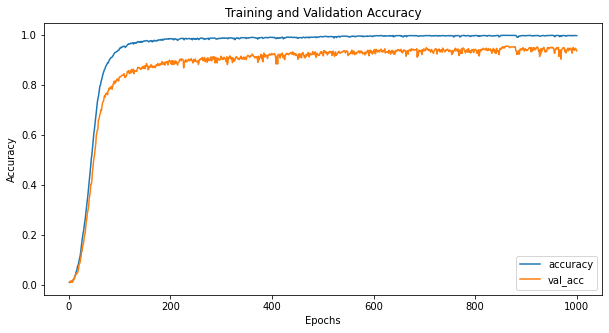

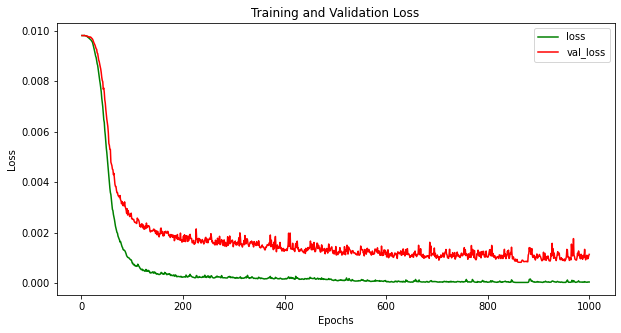

In [ ]:
history=history.history
epochs = range(1, len(history['loss']) + 1)
acc = history['accuracy']
loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

plt.figure(figsize=(10, 5))
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label='val_acc')
plt.legend()

plt.figure(figsize=(10, 5))
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, label='loss', color='g')
plt.plot(epochs, val_loss, label='val_loss', color='r')
plt.legend()


## 예측해보기(predict)

In [ ]:
y_pred = model.predict(X_test)

188/188 [==============================] - 2s 9ms/step


array([[44,  0,  0, ...,  0,  0,  0],
       [ 0, 57,  0, ...,  0,  0,  0],
       [ 0,  0, 65, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 68,  0,  0],
       [ 0,  0,  0, ...,  0, 67,  0],
       [ 0,  0,  0, ...,  0,  0, 57]])

In [ ]:
y_test_p=pd.DataFrame(y_test)

for i in range(1,101):
  y_test_p.loc[y_test_p[i] == 1.0 , 'y_test'] = i  
y_test_p.y_test

0       59.0
1       68.0
2       72.0
3        2.0
4       57.0
        ... 
5995     3.0
5996    87.0
5997    40.0
5998    68.0
5999    37.0
Name: y_test, Length: 6000, dtype: float64

In [ ]:
# ch1 = pd.DataFrame(np.rint(y_pred))
# for i in range(1,101):
#   ch1.loc[ch1[i] == 1.0 , 'pred'] = i 

 
#predict = pd.concat([data_test,ch1['pred'], y_test_p['y_test']],axis = 1)

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,pred
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
5996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.0
5997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0
5998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.0


In [ ]:
ex=np.argmax(y_pred, axis=1)
ex=ex.astype('float64')
ex=pd.DataFrame(ex)
ex

,0
0,59.0
1,68.0
2,72.0
3,2.0
4,57.0
...,...
5995,3.0
5996,87.0
5997,40.0
5998,68.0


In [ ]:
ch1 = pd.DataFrame(np.rint(y_pred))
ch1['pred'] = ex
data_test.reset_index(inplace=True, drop=True)
predict = pd.concat([data_test,ch1['pred'], y_test_p['y_test']],axis = 1)

In [ ]:
predict['compare'] = np.where(predict['pred']==predict['y_test'],'yes', 'no')

In [ ]:
predict_1 = predict[predict["compare"]=='no']
predict_1

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,pred,y_test,compare
30,0.001909,0.008317,0.014489,0.020412,0.025995,0.031137,0.035801,0.040075,0.044195,0.048538,...,0.044631,0.050399,0.057432,0.066046,0.076371,0.088327,0.101648,85.0,36.0,no
46,0.096114,0.095362,0.095047,0.095447,0.096676,0.098677,0.101247,0.104083,0.106844,0.109202,...,-0.004398,-0.008214,-0.013081,-0.019006,-0.025674,-0.032320,-0.037693,83.0,80.0,no
54,-0.041972,-0.048778,-0.055266,-0.061636,-0.067728,-0.073065,-0.076978,-0.078796,-0.078050,-0.074630,...,-0.102289,-0.108650,-0.114708,-0.119718,-0.122885,-0.123496,-0.121095,20.0,71.0,no
55,0.050686,0.056807,0.061922,0.066330,0.070463,0.074831,0.079964,0.086349,0.094365,0.104239,...,0.125449,0.136371,0.147691,0.159697,0.172642,0.186692,0.201860,41.0,50.0,no
71,-0.511413,-0.507140,-0.469849,-0.408462,-0.333769,-0.256404,-0.185178,-0.126038,-0.081724,-0.052058,...,0.031533,0.034874,0.038518,0.042180,0.045745,0.049241,0.052764,4.0,93.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5971,0.005315,-0.043084,-0.083200,-0.110473,-0.122973,-0.121490,-0.109050,-0.090022,-0.069069,-0.050204,...,-0.027012,-0.029614,-0.031356,-0.033020,-0.035244,-0.038329,-0.042129,95.0,23.0,no
5981,-0.005281,-0.018280,-0.031669,-0.042939,-0.050464,-0.053648,-0.052817,-0.048958,-0.043371,-0.037307,...,-0.016826,-0.013496,-0.011275,-0.010594,-0.011830,-0.015208,-0.020697,52.0,40.0,no
5992,-0.084734,-0.091664,-0.098196,-0.101411,-0.098148,-0.085744,-0.062829,-0.030004,0.009808,0.051498,...,0.072150,0.081214,0.090895,0.101388,0.112932,0.125713,0.139775,100.0,83.0,no
5994,0.008461,0.011468,0.012707,0.012096,0.009875,0.006558,0.002841,-0.000513,-0.002782,-0.003375,...,-0.048723,-0.051678,-0.052151,-0.050205,-0.046318,-0.041326,-0.036264,95.0,49.0,no
